# Import des librairies

In [10]:
# fonctions statistiques
import scipy.stats as st

# algèbre linéaire
import numpy as np 

# traitement des données
import pandas as pd

# graphiques et visualisation des données
import seaborn as sns
sns.set_theme(style="whitegrid") # style graphique des visualisations
%matplotlib inline
import matplotlib.pyplot as plt

# identification des types de données
from pandas.api.types import is_string_dtype, is_numeric_dtype

# imputation k-NN
import librairies.knn_impute as knn

# Chargement des données

In [2]:
path = 'data/openfoodfacts_data_for_analysis.csv'

In [3]:
open_food_facts_df = pd.read_csv(path, sep="\t")

# Exploration préliminaire des données

In [4]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 10 columns):
Unnamed: 0          104300 non-null int64
brands_tags         103844 non-null object
labels_en           71866 non-null object
additives_tags      73811 non-null object
nutriscore_grade    104300 non-null object
pnns_groups_1       104159 non-null object
pnns_groups_2       104300 non-null object
additives_n         104300 non-null float64
nutriscore_score    104300 non-null float64
nova_group          104067 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 8.0+ MB


L'index apparaît comme une variable dans le jeu de données exporté. Il sera supprimé car un nouvel index est créé lors du chargement.

In [4]:
open_food_facts_df.drop(columns=['Unnamed: 0'], inplace=True)

In [19]:
open_food_facts_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 9 columns):
brands_tags         103844 non-null object
labels_en           71866 non-null object
additives_tags      73811 non-null object
nutriscore_grade    104300 non-null object
pnns_groups_1       104159 non-null object
pnns_groups_2       104300 non-null object
additives_n         104300 non-null float64
nutriscore_score    104300 non-null float64
nova_group          104067 non-null float64
dtypes: float64(3), object(6)
memory usage: 45.1 MB


In [5]:
open_food_facts_df.describe(include='all')

brands_tags  labels_en    additives_tags nutriscore_grade  \
count       103844      71866             73811           104300   
unique       17089      21046             19093                5   
top              u  Green Dot  en:e322,en:e322i                d   
freq          3576       4116              3834            30566   
mean           NaN        NaN               NaN              NaN   
std            NaN        NaN               NaN              NaN   
min            NaN        NaN               NaN              NaN   
25%            NaN        NaN               NaN              NaN   
50%            NaN        NaN               NaN              NaN   
75%            NaN        NaN               NaN              NaN   
max            NaN        NaN               NaN              NaN   

        pnns_groups_1       pnns_groups_2    additives_n  nutriscore_score  \
count          104159              104300  104300.000000     104300.000000   
unique             13                  45            NaN               NaN   
top     Sugary snacks  Biscuits and cakes            NaN               NaN   
freq            22711               11070            NaN               NaN   
mean              NaN                 NaN       2.140489          9.488926   
std               NaN                 NaN       2.476332          8.933405   
min               NaN                 NaN       0.000000        -14.000000   
25%               NaN                 NaN       0.000000          2.000000   
50%               NaN                 NaN       1.000000         10.000000   
75%               NaN                 NaN       3.000000         16.000000   
max               NaN                 NaN      30.000000         40.000000   

           nova_group  
count   104067.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         3.512872  
std          0.875439  
min          1.000000  
25%          3.000000  
50%          4.000000  
75%          4.000000  
max          4.000000

Le jeu de données contient des données manquantes parmi les variables *brands_tags*, *labels_en*, *additives_tags*, *pnns_groups_1* et *nova_group*.

Nous allons les visualiser ci-dessus :

In [6]:
nombres_donnees_manquantes = open_food_facts_df.isnull().sum()
nombres_donnees_totales = open_food_facts_df.isnull().count()
pourcentages_donnees_manquantes = round(nombres_donnees_manquantes/nombres_donnees_totales*100, 1)

donnees_manquantes_df = pd.DataFrame({'nombre': nombres_donnees_manquantes, 
                                      'total': nombres_donnees_totales, 
                                      'pourcentage': pourcentages_donnees_manquantes})

donnees_manquantes_df.sort_values(by=['nombre'], ascending=False, inplace=True)

donnees_manquantes_df

nombre   total  pourcentage
labels_en          32434  104300         31.1
additives_tags     30489  104300         29.2
brands_tags          456  104300          0.4
nova_group           233  104300          0.2
pnns_groups_1        141  104300          0.1
nutriscore_grade       0  104300          0.0
pnns_groups_2          0  104300          0.0
additives_n            0  104300          0.0
nutriscore_score       0  104300          0.0

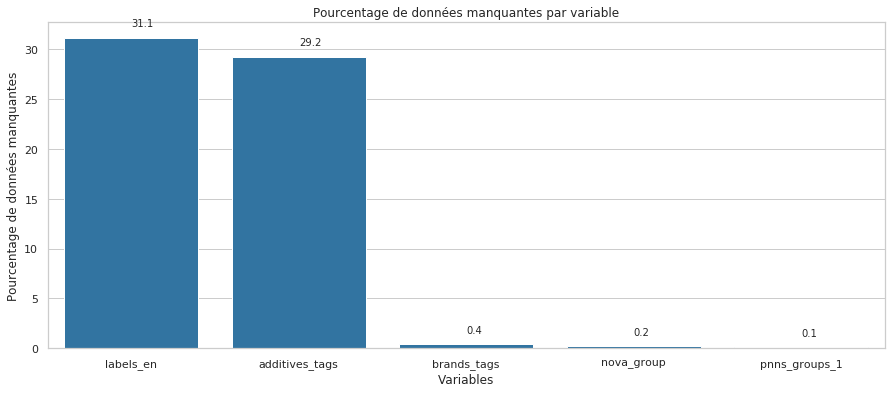

In [7]:
donnees_manquantes_df = donnees_manquantes_df[donnees_manquantes_df['nombre'] > 0]

plt.rcParams["figure.figsize"] = (15, 6)
sns.barplot(x=donnees_manquantes_df.index.values, y='pourcentage', data=donnees_manquantes_df, color='tab:blue')
plt.title('Pourcentage de données manquantes par variable')
plt.ylabel('Pourcentage de données manquantes')
plt.xlabel('Variables')

for variable, pourcentage in enumerate(donnees_manquantes_df.pourcentage):
    plt.text(variable, pourcentage, str(pourcentage)+"\n")

Les variables contenant une plus grande proportion de données manquantes sont *labels_en* et *additives_tags*, avec chacune 31.1% et 29.2% de données manquantes.

Il faudra porter une attention particulière lors de l'imputation de ces variables car la nouvelle valeur représentera environ 30% des données.

In [13]:
open_food_facts_df.head(12)

brands_tags  \
0                 crousresto   
1               comme-j-aime   
2               comme-j-aime   
3                        mx3   
4                wonka,nerds   
5               alice-delice   
6               alice-delice   
7                      vichy   
8   m-m-s,mars,mars-chocolat   
9                      pepsi   
10                     heinz   
11                 coca-cola   

                                            labels_en  \
0                                                 NaN   
1                  fr:viande-francaise,Made in France   
2                                           Green Dot   
3                                           Green Dot   
4                 No artificial flavors,Contains GMOs   
5                                                 NaN   
6                                         Gluten-free   
7   Low or no sugar,Contains a source of phenylala...   
8                                       Contains GMOs   
9                                                 NaN   
10  Vegetarian,No artificial colors,No flavors,No ...   
11                                                NaN   

                                       additives_tags nutriscore_grade  \
0                   en:e14xx,en:e262,en:e262i,en:e326                a   
1                           en:e14xx,en:e451,en:e451i                b   
2                     en:e102,en:e110,en:e407,en:e471                b   
3                                    en:e322,en:e322i                b   
4   en:e102,en:e110,en:e129,en:e132,en:e133,en:e29...                d   
5   en:e171,en:e339ii,en:e420,en:e420i,en:e422,en:...                d   
6   en:e330,en:e415,en:e420,en:e420ii,en:e422,en:e471                d   
7                                     en:e420,en:e951                c   
8                                             en:e414                e   
9                                    en:e150d,en:e338                e   
10                                   en:e101,en:e101i                d   
11                                            en:e338                e   

              pnns_groups_1         pnns_groups_2  additives_n  \
0      Cereals and potatoes                 Bread          3.0   
1           Composite foods        One-dish meals          2.0   
2   Milk and dairy products        Dairy desserts          4.0   
3     Fruits and vegetables                Fruits          1.0   
4             Sugary snacks                Sweets          7.0   
5                   unknown               unknown          5.0   
6             Sugary snacks                Sweets          5.0   
7             Sugary snacks                Sweets          2.0   
8             Sugary snacks                Sweets          1.0   
9                 Beverages   Sweetened beverages          2.0   
10           Fat and sauces  Dressings and sauces          1.0   
11                Beverages   Sweetened beverages          1.0   

    nutriscore_score  nova_group  
0               -4.0         4.0  
1                0.0         4.0  
2                2.0         4.0  
3                1.0         4.0  
4               14.0         4.0  
5               15.0         4.0  
6               18.0         4.0  
7                3.0         4.0  
8               36.0         4.0  
9               13.0         4.0  
10              14.0         4.0  
11              14.0         4.0

In [5]:
# identification des types de variables
variables_numeriques = []
variables_qualitatives = []

for variable in open_food_facts_df:
    if is_numeric_dtype(open_food_facts_df[variable]):
        variables_numeriques.append(variable)
    elif is_string_dtype(open_food_facts_df[variable]):
        variables_qualitatives.append(variable)
        
print(variables_numeriques)
print(variables_qualitatives)

['additives_n', 'nutriscore_score', 'nova_group']
['brands_tags', 'labels_en', 'additives_tags', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2']


# Analyses univariées

Avant de réaliser les analyses, je vais d'abord modifier le type de donnée de *nova_group*.

In [6]:
open_food_facts_df = open_food_facts_df.astype({'nova_group': 'object'})

In [7]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   brands_tags       103844 non-null  object 
 1   labels_en         71866 non-null   object 
 2   additives_tags    73811 non-null   object 
 3   nutriscore_grade  104300 non-null  object 
 4   pnns_groups_1     104159 non-null  object 
 5   pnns_groups_2     104300 non-null  object 
 6   additives_n       104300 non-null  float64
 7   nutriscore_score  104300 non-null  float64
 8   nova_group        104067 non-null  object 
dtypes: float64(2), object(7)
memory usage: 7.2+ MB


## *Nova_group* : classification NOVA des produits

In [106]:
open_food_facts_df['nova_group'].value_counts()

4.0    71633
3.0    22792
1.0     8618
2.0     1024
Name: nova_group, dtype: int64

Text(0, 0.5, 'Nombre de produits')

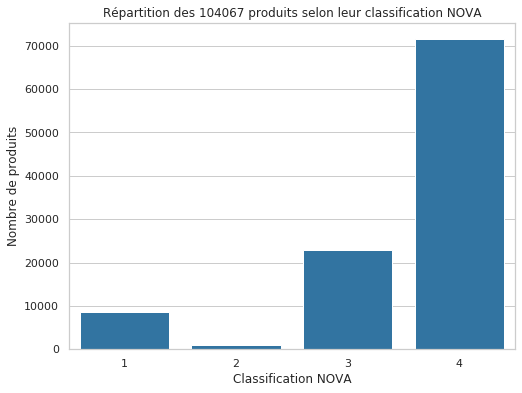

In [105]:
nombre_produits = open_food_facts_df['nova_group'].count()
plt.rcParams["figure.figsize"] = (8, 6)
sns.countplot(x='nova_group', data=open_food_facts_df, color='tab:blue', order=[1,2,3,4])
plt.title('Répartition des {} produits selon leur classification NOVA'.format(nombre_produits))
plt.xlabel('Classification NOVA')
plt.ylabel('Nombre de produits')

#for variable, pourcentage in enumerate(donnees_manquantes_df.pourcentage):
 #   plt.text(variable, pourcentage, str(pourcentage)+"\n")

La plupart des produits (environ 70%) sont ultra-transformés.

## *nutriscore_grade* : classement Nutri-Score des produits

In [107]:
open_food_facts_df['nutriscore_grade'].value_counts()

d    30566
c    23016
e    22130
a    14474
b    14114
Name: nutriscore_grade, dtype: int64

Text(0, 0.5, 'Nombre de produits')

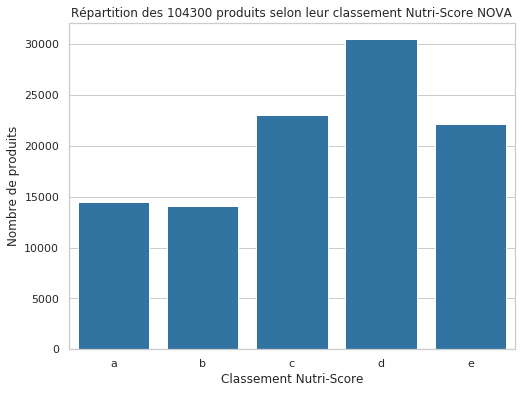

In [109]:
nombre_produits = open_food_facts_df['nutriscore_grade'].count()
plt.rcParams["figure.figsize"] = (8, 6)
sns.countplot(x='nutriscore_grade', data=open_food_facts_df, color='tab:blue', order=['a', 'b', 'c', 'd', 'e'])
plt.title('Répartition des {} produits selon leur classement Nutri-Score'.format(nombre_produits))
plt.xlabel('Classement Nutri-Score')
plt.ylabel('Nombre de produits')

#for variable, pourcentage in enumerate(donnees_manquantes_df.pourcentage):
 #   plt.text(variable, pourcentage, str(pourcentage)+"\n")

La plupart des produits ont un Nutri-Score moyen ou mauvais (environ 70%).

## *nutriscore_score* : score final Nutri-Score des produits

In [110]:
open_food_facts_df['nutriscore_score'].describe()

count    104300.000000
mean          9.488926
std           8.933405
min         -14.000000
25%           2.000000
50%          10.000000
75%          16.000000
max          40.000000
Name: nutriscore_score, dtype: float64

Text(-3.8249999999999957, 0.5, 'Nombre de produits')

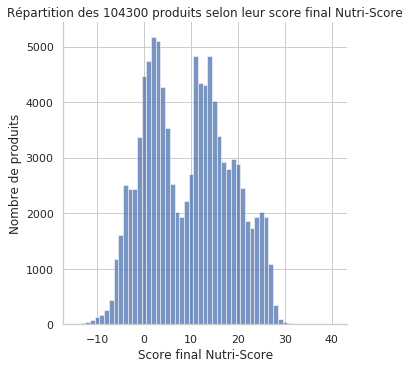

In [114]:
# Distribution du score final Nutri-Score
nombre_produits = open_food_facts_df['nutriscore_score'].count()
sns.displot(x='nutriscore_score', data=open_food_facts_df, discrete=True)
plt.title('Répartition des {} produits selon leur score final Nutri-Score'.format(nombre_produits))
plt.xlabel('Score final Nutri-Score')
plt.ylabel('Nombre de produits')

Text(0.5, 0, 'Score final Nutri-Score')

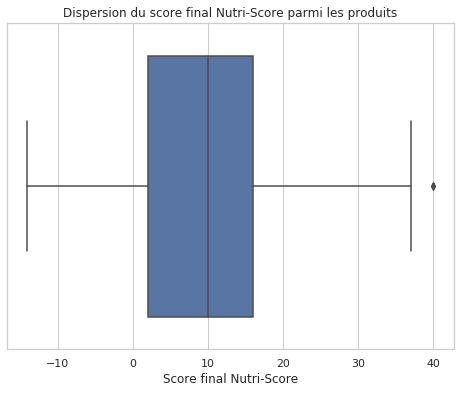

In [115]:
# Dispersion du score final Nutri-Score
sns.boxplot(x='nutriscore_score', data=open_food_facts_df)
plt.title('Dispersion du score final Nutri-Score parmi les produits')
plt.xlabel('Score final Nutri-Score')

Voyons quels produits sont les outliers sur leur score final du Nutri-Score.

In [116]:
open_food_facts_df[open_food_facts_df['nutriscore_score'] == 40]

brands_tags labels_en           additives_tags nutriscore_grade  \
8012      cynxshno       NaN                 en:e150d                e   
90646  body-attack       NaN  en:e551,en:e950,en:e955                e   

      pnns_groups_1          pnns_groups_2  additives_n  nutriscore_score  \
8012      Beverages  Unsweetened beverages          1.0              40.0   
90646       unknown                unknown          3.0              40.0   

      nova_group  
8012           4  
90646          4

Le premier produit est une boisson de Pologne. Le deuxième un complément alimentaire de protéines.

## *additives_n* : nombre d'additifs des produits

In [117]:
open_food_facts_df['additives_n'].describe()

count    104300.000000
mean          2.140489
std           2.476332
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          30.000000
Name: additives_n, dtype: float64

Text(-10.824999999999996, 0.5, 'Nombre de produits')

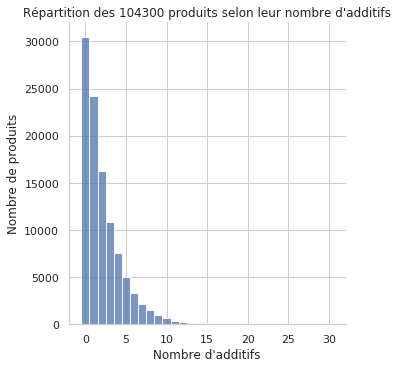

In [118]:
# Distribution du nombre d'additifs des produits
nombre_produits = open_food_facts_df['additives_n'].count()
sns.displot(x='additives_n', data=open_food_facts_df, discrete=True)
plt.title('Répartition des {} produits selon leur nombre d\'additifs'.format(nombre_produits))
plt.xlabel('Nombre d\'additifs')
plt.ylabel('Nombre de produits')

La plupart des produits n'ont aucun additif ou en ont très peu. Pour 75% d'entre eux, il y en a 3 au maximum.

Text(0.5, 0, "Nombre d'additifs")

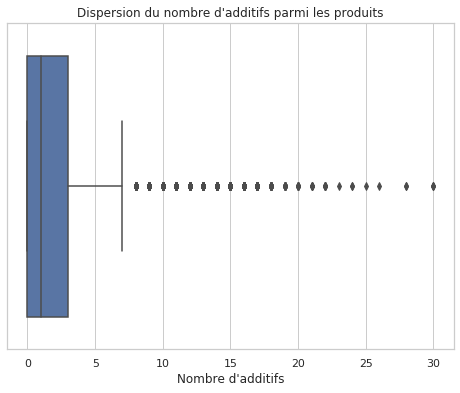

In [119]:
# Dispersion du nombre d'additifs des produits
sns.boxplot(x='additives_n', data=open_food_facts_df)
plt.title('Dispersion du nombre d\'additifs parmi les produits')
plt.xlabel('Nombre d\'additifs')

Voyons quels produits sont les outliers sur leur nombre d'additifs.

In [19]:
filtered_df = open_food_facts_df[open_food_facts_df['additives_n'] > 7]
filtered_df.sample(30)

brands_tags  \
4737                      chef-select-to-go   
37914                          leader-price   
78633                      poppies-berlidon   
14029                                haribo   
93069                                 winny   
9656    la-laitiere,nestle,secret-de-mousse   
81954             les-delices-des-7-vallees   
102760                          look-o-look   
52734                              monoprix   
21445                                casino   
41774                            le-gaulois   
59881                            rochambeau   
26183                          claude-leger   
102959                           carte-d-or   
54714   collection-saveurs-d-asie,carrefour   
61504                            mamie-nova   
50111                             charculor   
94487                              nawhal-s   
13895                                haribo   
13943                                haribo   
61526                                  nova   
71332                         marque-repere   
45911                                vedere   
18200                                charal   
93068                                 winny   
90373                        marque-blanche   
72233                                hafner   
39598                          leader-price   
3141                                leclerc   
14013                                haribo   

                                                labels_en  \
4737                                                  NaN   
37914                                                 NaN   
78633                                      Made in France   
14029                                                 NaN   
93069          Green Dot,Made in France,fr:eco-emballages   
9656    Green Dot,New,fr:eco-emballages,fr:nutritional...   
81954                                                 NaN   
102760                         FSC,FSC Mix,fr:fsc-c021442   
52734                                           Green Dot   
21445                                                 NaN   
41774   French meat,No preservatives,Palm-oil-free,fr:...   
59881                                                 NaN   
26183                                          Nutriscore   
102959                                          Green Dot   
54714                                                 NaN   
61504                                                 NaN   
50111                                                 NaN   
94487                                               Halal   
13895                                                 NaN   
13943                                                 NaN   
61526                                                 NaN   
71332                       Nutriscore,Nutriscore Grade C   
45911                               Green Dot,Pure butter   
18200   French meat,Kosher,Orthodox Union Kosher,fr:Vi...   
93068          Green Dot,Made in France,fr:eco-emballages   
90373                                               Halal   
72233                                                 NaN   
39598                                                 NaN   
3141                                                  NaN   
14013                                                 NaN   

                                           additives_tags nutriscore_grade  \
4737    en:e14xx,en:e160c,en:e161b,en:e202,en:e224,en:...                d   
37914   en:e14xx,en:e160c,en:e161b,en:e202,en:e260,en:...                e   
78633   en:e14xx,en:e160a,en:e160c,en:e171,en:e202,en:...                e   
14029   en:e100,en:e131,en:e141,en:e141ii,en:e153,en:e...                d   
93069   en:e14xx,en:e160,en:e262,en:e300,en:e322,en:e3...                c   
9656    en:e100,en:e14xx,en:e160a,en:e160ai,en:e171,en...                c   
81954   en:e14xx,en:e160a,en:e160b,en:e202,en:e300,en:...                d   
102760  en:e100,en:e120,en:e133,en:e150d,en:e153,en:e1... 

In [58]:
st.skew(open_food_facts_df['additives_n'])

1.9621323603043257

La distribution du nombre d'additifs est totalement asymétrique, le coefficient de skewness valant 1.96 le confirme car il est positif. Il y aura besoin de transformer cette variable avec le log avant d'utiliser le dataset pour entraîner un modèle.

Voyons les stats des produits sans les outliers :

In [16]:
filtered_df = open_food_facts_df[open_food_facts_df['additives_n'] < 8]
filtered_df['additives_n'].describe()

count    99929.000000
mean         1.799508
std          1.833887
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max          7.000000
Name: additives_n, dtype: float64

## *pnns_groups_1* : catégorie principale des produits

In [134]:
open_food_facts_df['pnns_groups_1'].value_counts()

Sugary snacks              22711
Composite foods            13098
Fish Meat Eggs             12689
Milk and dairy products    12460
Cereals and potatoes        8721
Beverages                   7807
Salty snacks                6897
unknown                     6141
Fruits and vegetables       6140
Fat and sauces              5396
sugary-snacks               1383
fruits-and-vegetables        712
cereals-and-potatoes           4
Name: pnns_groups_1, dtype: int64

Text(0.5, 0, 'Nombre de produits')

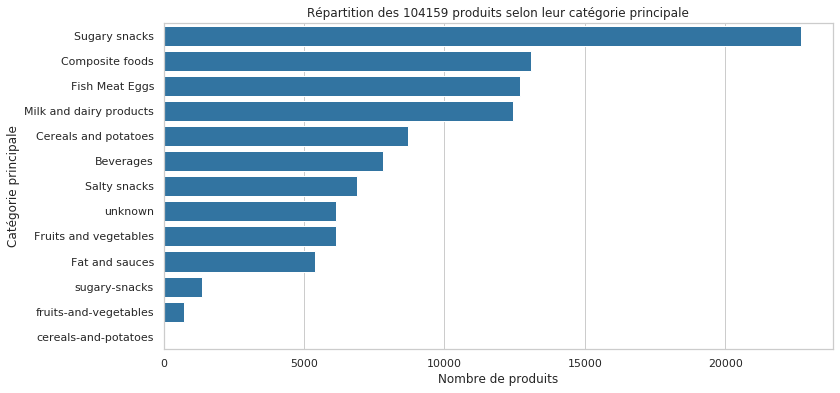

In [136]:
ordre_categorie = open_food_facts_df['pnns_groups_1'].value_counts().index
nombre_produits = open_food_facts_df['pnns_groups_1'].count()
plt.rcParams["figure.figsize"] = (12, 6)
sns.countplot(y='pnns_groups_1', data=open_food_facts_df, color='tab:blue', order=ordre_categorie)
plt.title('Répartition des {} produits selon leur catégorie principale'.format(nombre_produits))
plt.ylabel('Catégorie principale')
plt.xlabel('Nombre de produits')

#for variable, pourcentage in enumerate(donnees_manquantes_df.pourcentage):
 #   plt.text(variable, pourcentage, str(pourcentage)+"\n")

Les deux principales catégories représentées parmi les produits sont les snacks sucrés et les plats préparés. On peut remarquer que trois catégories sont doublonnées : *sugary-snacks*, *fruits-and-vegetables* et *cereals-and-potatoes*. Ces catégories devront être regroupées avec leur doublon.

On note également que les produits de bonne qualité nutritionnelle tels que les fruits, légumes et céréales sont peu représentés dans notre jeu de données.

Regroupons les catégories concernées.

In [17]:
open_food_facts_df['pnns_groups_1'].replace(['sugary-snacks', 'fruits-and-vegetables', 'cereals-and-potatoes'],
                                           ['Sugary snacks', 'Fruits and vegetables', 'Cereals and potatoes'],
                                           inplace=True)

In [18]:
open_food_facts_df['pnns_groups_1'].value_counts()

Sugary snacks              24094
Composite foods            13098
Fish Meat Eggs             12689
Milk and dairy products    12460
Cereals and potatoes        8725
Beverages                   7807
Salty snacks                6897
Fruits and vegetables       6852
unknown                     6141
Fat and sauces              5396
Name: pnns_groups_1, dtype: int64

Text(0.5, 0, 'Nombre de produits')

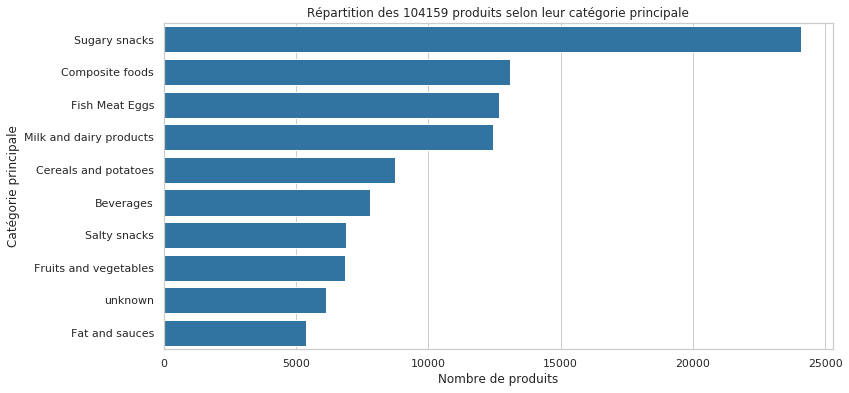

In [24]:
ordre_categorie = open_food_facts_df['pnns_groups_1'].value_counts().index
nombre_produits = open_food_facts_df['pnns_groups_1'].count()
plt.rcParams["figure.figsize"] = (12, 6)
sns.countplot(y='pnns_groups_1', data=open_food_facts_df, color='tab:blue', order=ordre_categorie)
plt.title('Répartition des {} produits selon leur catégorie principale'.format(nombre_produits))
plt.ylabel('Catégorie principale')
plt.xlabel('Nombre de produits')

## *pnns_groups_2* : catégorie secondaire des produits

In [137]:
open_food_facts_df['pnns_groups_2'].value_counts()

Biscuits and cakes                  11070
One-dish meals                      10693
Sweets                               8043
Processed meat                       6718
unknown                              6141
Dressings and sauces                 4356
Cheese                               4250
Milk and yogurt                      4144
Salty and fatty products             3621
Chocolate products                   3598
Cereals                              3502
Sweetened beverages                  3284
Meat                                 2775
Appetizers                           2700
Fish and seafood                     2647
Bread                                2322
Vegetables                           2291
Dairy desserts                       2215
Fruits                               2155
Ice cream                            1851
Breakfast cereals                    1512
Fruit juices                         1449
pastries                             1383
Pizza pies and quiche             

Text(0.5, 0, 'Nombre de produits')

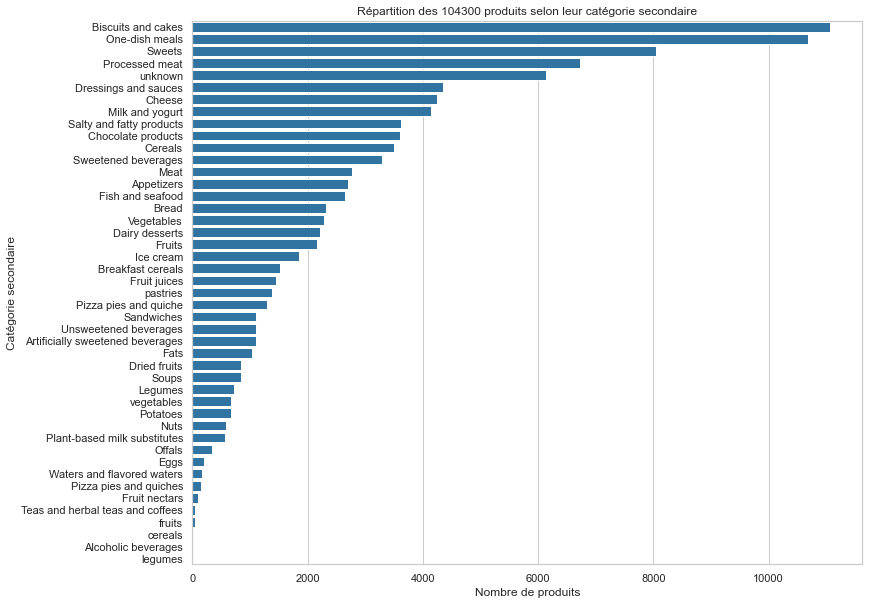

In [19]:
ordre_categorie = open_food_facts_df['pnns_groups_2'].value_counts().index
nombre_produits = open_food_facts_df['pnns_groups_2'].count()
plt.rcParams["figure.figsize"] = (12, 10)
sns.countplot(y='pnns_groups_2', data=open_food_facts_df, color='tab:blue', order=ordre_categorie)
plt.title('Répartition des {} produits selon leur catégorie secondaire'.format(nombre_produits))
plt.ylabel('Catégorie secondaire')
plt.xlabel('Nombre de produits')

#for variable, pourcentage in enumerate(donnees_manquantes_df.pourcentage):
 #   plt.text(variable, pourcentage, str(pourcentage)+"\n")

Les principales sous-catégories représentées parmi les produits sont les biscuits, gâteaux, plats préparés, bonbons et la viande transformée.

Les catégories qui pourront être rassemblées en une seule sont :
- *Vegetables*, *vegetables*, *legumes* et *Legumes* 
- *Fruits* et *fruits*
- *Cereals* et *cereals*
- *Pizza pies and quiche* et *Pizza pies and quiches*

Regroupons ces sous-catégories.

In [20]:
open_food_facts_df['pnns_groups_2'].replace(
                        ['fruits', 'legumes', 'Legumes', 'vegetables', 'cereals', 'Pizza pies and quiches'],
                        ['Fruits', 'Vegetables', 'Vegetables', 'Vegetables', 'Cereals', 'Pizza pies and quiche'],
                        inplace=True)

In [12]:
open_food_facts_df['pnns_groups_2'].value_counts()

Biscuits and cakes                  11070
One-dish meals                      10693
Sweets                               8043
Processed meat                       6718
unknown                              6141
Dressings and sauces                 4356
Cheese                               4250
Milk and yogurt                      4144
Vegetables                           3679
Salty and fatty products             3621
Chocolate products                   3598
Cereals                              3505
Sweetened beverages                  3284
Meat                                 2775
Appetizers                           2700
Fish and seafood                     2647
Bread                                2322
Dairy desserts                       2215
Fruits                               2195
Ice cream                            1851
Breakfast cereals                    1512
Fruit juices                         1449
Pizza pies and quiche                1433
pastries                          

Text(0.5, 0, 'Nombre de produits')

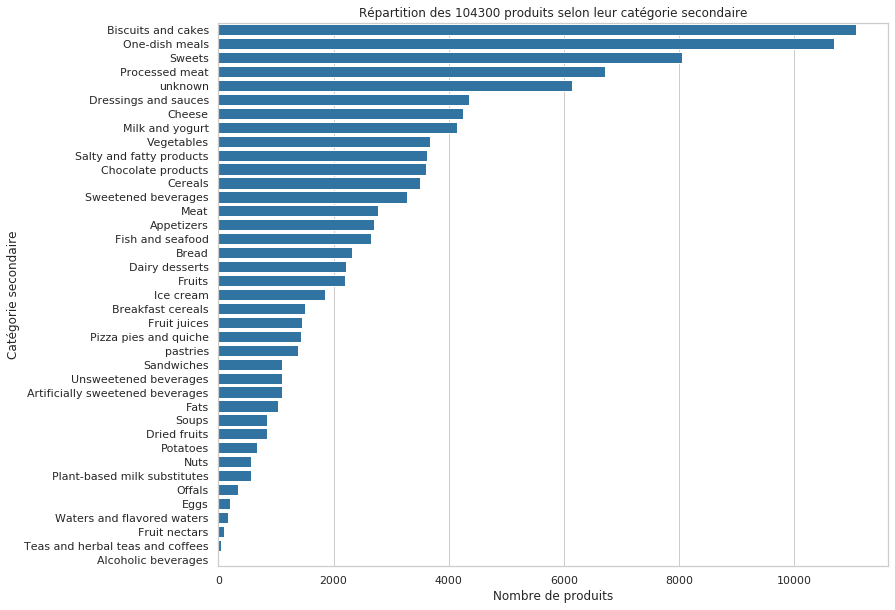

In [29]:
ordre_categorie = open_food_facts_df['pnns_groups_2'].value_counts().index
nombre_produits = open_food_facts_df['pnns_groups_2'].count()
plt.rcParams["figure.figsize"] = (12, 10)
sns.countplot(y='pnns_groups_2', data=open_food_facts_df, color='tab:blue', order=ordre_categorie)
plt.title('Répartition des {} produits selon leur catégorie secondaire'.format(nombre_produits))
plt.ylabel('Catégorie secondaire')
plt.xlabel('Nombre de produits')

## *brands_tags* : marque des produits

In [33]:
open_food_facts_df['brands_tags'].value_counts().head(30)

u                            3576
auchan                       3107
carrefour                    2965
casino                       2035
leader-price                 1688
picard                       1325
cora                         1116
fleury-michon                 799
netto                         782
monoprix                      721
belle-france                  716
la-vie-claire                 669
franprix                      631
le-gaulois                    532
thiriet                       506
bio-village,marque-repere     446
u-saveurs,u                   397
u-bio,u                       383
nestle                        369
dia                           330
monique-ranou                 327
sans-marque                   322
bjorg                         321
casino-bio,casino             285
yoplait                       284
haribo                        278
andros                        276
paturages                     271
knorr                         264
bonduelle     

La plupart des marques représentées sont des chaînes de la grande distribution ou des entreprises de l'agro-alimentaire. La variable peut donner aussi une indication sur le lieu d'achat du produit.

## *labels_en* : label portés par les produits

In [34]:
open_food_facts_df['labels_en'].value_counts().head(30)

Green Dot                                                                       4116
Made in France                                                                  3010
Organic                                                                         2244
Organic,EU Organic,AB Agriculture Biologique                                    1700
No preservatives                                                                1037
No colorings,No preservatives                                                    823
PDO                                                                              763
Gluten-free                                                                      750
Green Dot,Made in France                                                         718
No colorings                                                                     525
Green Dot,fr:eco-emballages                                                      501
Palm-oil-free                                                    

In [35]:
open_food_facts_df['labels_en'].str.find("preservatives").describe()

count    71866.000000
mean         2.875059
std         15.074944
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        283.000000
Name: labels_en, dtype: float64

In [37]:
open_food_facts_df[open_food_facts_df['labels_en'].str.find("preservatives") > -1]

brands_tags                                          labels_en  \
10              heinz  Vegetarian,No artificial colors,No flavors,No ...   
18              heinz               No preservatives,No thickening agent   
31             genius                       Gluten-free,No preservatives   
99             liebig     Cooked in France,No colorings,No preservatives   
201         koon-chun                                   No preservatives   
...               ...                                                ...   
104270          yeo-s                                   No preservatives   
104275        pa-food  Vegetarian,Halal,Vegan,No cholesterol,No prese...   
104279          kawan                                   No preservatives   
104280       marigold                          FSC,No-preservativeshalal   
104288  giovanni-rana                     No preservatives,Palm-oil-free   

                         additives_tags nutriscore_grade  \
10                     en:e101,en:e101i                d   
18                                  NaN                d   
31                      en:e422,en:e464                b   
99                             en:e14xx                c   
201                             en:e401                c   
...                                 ...              ...   
104270  en:e407,en:e452,en:e471,en:e500                b   
104275                              NaN                b   
104279                          en:e500                c   
104280          en:e296,en:e330,en:e466                b   
104288                              NaN                c   

                pnns_groups_1                 pnns_groups_2  additives_n  \
10             Fat and sauces          Dressings and sauces          1.0   
18             Fat and sauces          Dressings and sauces          0.0   
31       Cereals and potatoes                         Bread          2.0   
99      Fruits and vegetables                         Soups          1.0   
201            Fat and sauces          Dressings and sauces          1.0   
...                       ...                           ...          ...   
104270              Beverages  Plant-based milk substitutes          4.0   
104275   Cereals and potatoes                         Bread          0.0   
104279   Cereals and potatoes                         Bread          1.0   
104280                unknown                       unknown          3.0   
104288   Cereals and potatoes                      Potatoes          0.0   

        nutriscore_score nova_group  
10                  14.0          4  
18                  13.0          3  
31                   0.0          4  
99                   3.0          4  
201                  6.0          4  
...                  ...        ...  
104270               0.0          4  
104275               2.0          3  
104279              10.0          3  
104280               2.0          4  
104288               4.0          4  

[8001 rows x 9 columns]

In [38]:
open_food_facts_df['labels_en'].str.find("additives").describe()

count    71866.000000
mean        -0.503326
std          5.985629
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        222.000000
Name: labels_en, dtype: float64

In [39]:
open_food_facts_df[open_food_facts_df['labels_en'].str.find("additives") > -1]

brands_tags                                          labels_en  \
125           thai-kitchen                                       No additives   
261     lily-of-the-desert              Organic,No additives,No preservatives   
669           old-dominion          Gluten-free,No additives,No preservatives   
877         thomas-brioche         No colorings,No preservatives,No additives   
978              carrefour                                       No additives   
...                    ...                                                ...   
103258              vivera                    No additives,With Sunflower oil   
103336            body-fit  Low or no salt,Organic,EU Organic,EU/non-EU Ag...   
104222        meadow-fresh                      No additives,No preservatives   
104225        mother-earth                                       No additives   
104243           bio-lanka  Organic,Vegetarian,EU Organic,Gluten-free,Vega...   

       additives_tags nutriscore_grade          pnns_groups_1  \
125               NaN                d              Beverages   
261           en:e330                b              Beverages   
669               NaN                c           Salty snacks   
877               NaN                d          Sugary snacks   
978               NaN                e          Sugary snacks   
...               ...              ...                    ...   
103258            NaN                a                unknown   
103336            NaN                a          Sugary snacks   
104222            NaN                b                unknown   
104225            NaN                d   Cereals and potatoes   
104243            NaN                a  Fruits and vegetables   

                       pnns_groups_2  additives_n  nutriscore_score nova_group  
125     Plant-based milk substitutes          0.0              11.0          1  
261            Unsweetened beverages          1.0               1.0        NaN  
669                             Nuts          0.0               3.0          3  
877                         pastries          0.0              17.0          4  
978               Biscuits and cakes          0.0              21.0          4  
...                              ...          ...               ...        ...  
103258                       unknown          0.0              -5.0          4  
103336                        Sweets          0.0              -2.0          1  
104222                       unknown          0.0               1.0          1  
104225                    Vegetables          0.0              14.0          4  
104243                        Fruits          0.0              -5.0          1  

[1087 rows x 9 columns]

Au vu de la grande diversité des labels présents sur les produits. Tous ne seront pas utiles pour l'analyse et l'application, il sera intéressant de travailler sur les labels de type "No additives" ou "No preservatives".

## *additives_tags* : liste d'additifs présents dans les produits

In [43]:
open_food_facts_df['additives_tags'].value_counts().head(30)

en:e322,en:e322i                      3834
en:e330                               2802
en:e440                               2540
en:e14xx                              1969
en:e300                               1870
en:e250,en:e301                       1248
en:e300,en:e330                        912
en:e250                                818
en:e407                                812
en:e250,en:e316                        748
en:e330,en:e440                        745
en:e415                                593
en:e252                                571
en:e412                                502
en:e202                                493
en:e471                                487
en:e412,en:e415                        458
en:e14xx,en:e415                       393
en:e160c                               357
en:e160b                               330
en:e500,en:e500ii                      323
en:e224,en:e330                        306
en:e270                                284
en:e250,en:

# Analyses multivariées

In [25]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 9 columns):
brands_tags         103844 non-null object
labels_en           71866 non-null object
additives_tags      73811 non-null object
nutriscore_grade    104300 non-null object
pnns_groups_1       104159 non-null object
pnns_groups_2       104300 non-null object
additives_n         104300 non-null float64
nutriscore_score    104300 non-null float64
nova_group          104067 non-null object
dtypes: float64(2), object(7)
memory usage: 7.2+ MB


## Y a-t-il plus d'additifs lorsque les produits ont une faible qualité nutritionnelle ?

Text(0.5, 0, "Nombre d'additifs")

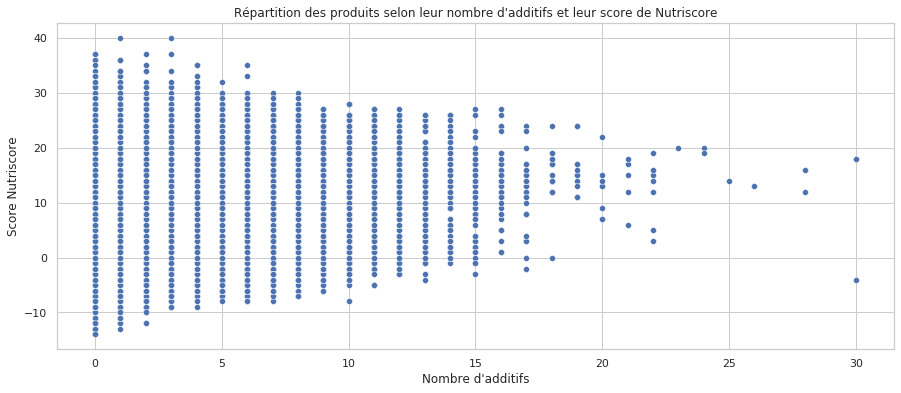

In [28]:
sns.scatterplot(data=open_food_facts_df, x="additives_n", y="nutriscore_score")
plt.title('Répartition des produits selon leur nombre d\'additifs et leur score de Nutriscore')
plt.ylabel('Score Nutriscore')
plt.xlabel('Nombre d\'additifs')

In [26]:
open_food_facts_df.corr()

additives_n  nutriscore_score
additives_n           1.00000           0.18417
nutriscore_score      0.18417           1.00000

Il ne semble pas avoir de corrélation entre le nombre d'additifs et le score Nutriscore.

Considérons plutôt ces variables comme qualitatives pour vérifier leur indépendance entre elles. Dressons alors le tableau de contingence.

In [31]:
X = "additives_n"
Y = "nutriscore_score"
tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len, 
                                                             margins=True,
                                                             margins_name="Total")

tableau_contingence

nutriscore_score  -14.0  -13.0  -12.0  -11.0  -10.0   -9.0   -8.0   -7.0  \
additives_n                                                                
0.0                 4.0   15.0   41.0   69.0  107.0  147.0  211.0  334.0   
1.0                 NaN    1.0    3.0    4.0   13.0   15.0   24.0   58.0   
2.0                 NaN    NaN    2.0    NaN    4.0    4.0   14.0   27.0   
3.0                 NaN    NaN    NaN    NaN    NaN    3.0    7.0   10.0   
4.0                 NaN    NaN    NaN    NaN    NaN    1.0    1.0    2.0   
5.0                 NaN    NaN    NaN    NaN    NaN    NaN    1.0    2.0   
6.0                 NaN    NaN    NaN    NaN    NaN    NaN    2.0    2.0   
7.0                 NaN    NaN    NaN    NaN    NaN    NaN    1.0    1.0   
8.0                 NaN    NaN    NaN    NaN    NaN    NaN    NaN    2.0   
9.0                 NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
10.0                NaN    NaN    NaN    NaN    NaN    NaN    1.0    NaN   
11.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
13.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
14.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
15.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
16.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
17.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
19.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
20.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
21.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
22.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
23.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
24.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
25.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
26.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
28.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
30.0                NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Total               4.0   16.0   46.0   73.0  124.0  170.0  262.0  438.0   

nutriscore_score    -6.0    -5.0  ...  30.0  31.0  32.0  33.0  34.0  35.0  \
additives_n                       ...                                       
0.0                891.0   926.0  ...   6.0   6.0   4.0   4.0   1.0   1.0   
1.0                164.0   350.0  ...  12.0   9.0   5.0   2.0   3.0   NaN   
2.0                 71.0   224.0  ...  12.0   3.0   1.0   NaN   2.0   2.0   
3.0                 20.0    46.0  ...   1.0   3.0   1.0   NaN   1.0   NaN   
4.0                  8.0    38.0  ...   5.0   4.0   1.0   2.0   NaN   2.0   
5.0                 13.0     9.0  ...   2.0   NaN   1.0   NaN   NaN   NaN   
6.0                  5.0     8.0  ...   2.0   NaN   NaN   1.0   NaN   1.0   
7.0                  3.0     9.0  ...   1.0   NaN   NaN   NaN   NaN   NaN   
8.0                  2.0     1.0  ...   1.0   NaN   NaN   NaN   NaN   NaN   
9.0                  2.0     2.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   
10.0                 NaN     1.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   
11.0                 NaN     2.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   
12.0                 NaN     NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
13.0                 NaN     NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
14.0                 NaN     NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
15.0                 NaN     NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
16.0                 NaN     NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
17.0                 NaN     NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
18.0                 NaN   

Au vu du tableau de contingence, il est préférable de créer des classes pour la variable 'nombre d'additifs' et d'utiliser la classe du nutriscore au lieu du score.

Création des classes du nombre d'additifs :

In [12]:
open_food_facts_df.loc[open_food_facts_df['additives_n'] == 0, 'additives_n_classes'] = 'Pas d\'additif'
open_food_facts_df.loc[(open_food_facts_df['additives_n'] == 1) | (open_food_facts_df['additives_n'] == 2), 
                   'additives_n_classes'] = '1 ou 2 additifs'
open_food_facts_df.loc[(open_food_facts_df['additives_n'] >= 3) & (open_food_facts_df['additives_n'] <= 7), 
                   'additives_n_classes'] = 'Entre 3 et 7 additifs'
open_food_facts_df.loc[open_food_facts_df['additives_n'] > 7, 'additives_n_classes'] = 'Plus de 7 additifs'

In [13]:
open_food_facts_df[['additives_n', 'additives_n_classes']].sample(30)

additives_n    additives_n_classes
17239           2.0        1 ou 2 additifs
56612           2.0        1 ou 2 additifs
74767           5.0  Entre 3 et 7 additifs
47              1.0        1 ou 2 additifs
57632           0.0          Pas d'additif
14486           1.0        1 ou 2 additifs
83192           5.0  Entre 3 et 7 additifs
29480           3.0  Entre 3 et 7 additifs
39495           1.0        1 ou 2 additifs
2787            2.0        1 ou 2 additifs
10626           0.0          Pas d'additif
86501           0.0          Pas d'additif
23524           5.0  Entre 3 et 7 additifs
32914           0.0          Pas d'additif
51753           1.0        1 ou 2 additifs
31065           2.0        1 ou 2 additifs
67640           0.0          Pas d'additif
103510          3.0  Entre 3 et 7 additifs
88927           0.0          Pas d'additif
93191           0.0          Pas d'additif
35890           0.0          Pas d'additif
76692           0.0          Pas d'additif
22814           0.0          Pas d'additif
72888           3.0  Entre 3 et 7 additifs
88152           1.0        1 ou 2 additifs
24849           5.0  Entre 3 et 7 additifs
153             4.0  Entre 3 et 7 additifs
30202           4.0  Entre 3 et 7 additifs
56399           1.0        1 ou 2 additifs
45468           4.0  Entre 3 et 7 additifs

In [40]:
open_food_facts_df['additives_n'].value_counts()

0.0     30489
1.0     24228
2.0     16296
3.0     10879
4.0      7521
5.0      5006
6.0      3318
7.0      2192
8.0      1513
9.0       999
10.0      657
11.0      365
12.0      263
13.0      173
14.0      151
15.0       96
16.0       52
17.0       37
18.0       22
19.0       13
20.0        8
22.0        7
21.0        5
30.0        3
24.0        2
28.0        2
26.0        1
23.0        1
25.0        1
Name: additives_n, dtype: int64

In [41]:
open_food_facts_df['additives_n_classes'].value_counts()

1 ou 2 additifs          40524
Pas d'additif            30489
Entre 3 et 7 additifs    28916
Plus de 7 additifs        4371
Name: additives_n_classes, dtype: int64

In [44]:
open_food_facts_df['additives_n_classes'].index

RangeIndex(start=0, stop=104300, step=1)

Text(0, 0.5, 'Score Nutri-Score')

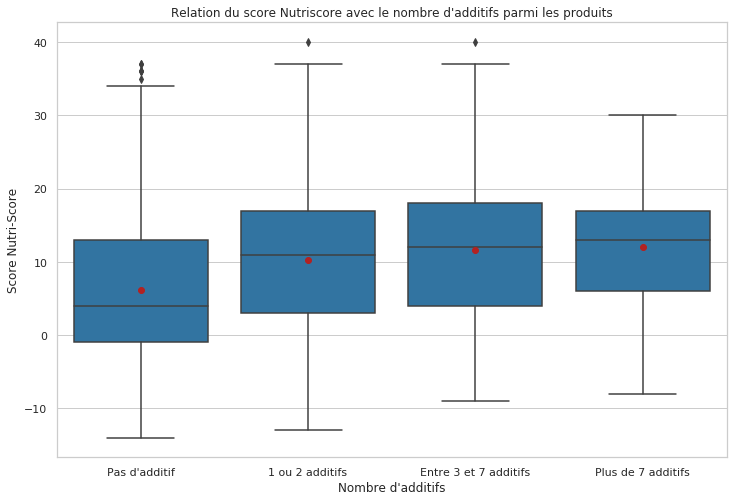

In [70]:
meanprops = {'marker':'o', 'markeredgecolor':'firebrick',
            'markerfacecolor':'firebrick'}

plt.rcParams["figure.figsize"] = (12, 8)
sns.boxplot(x='additives_n_classes', y='nutriscore_score', 
            data=open_food_facts_df, color='tab:blue',
            order=['Pas d\'additif', '1 ou 2 additifs', 'Entre 3 et 7 additifs', 'Plus de 7 additifs'],
            showmeans=True,
            meanprops=meanprops)
plt.title('Relation du score Nutriscore avec le nombre d\'additifs parmi les produits')
plt.xlabel('Nombre d\'additifs')
plt.ylabel('Score Nutri-Score')

Le score moyen et médian est plus faible parmi les produits sans additif. Il semble donc que ces produits aient une meilleure qualité nutritionnelle.

Confirmons-le avec une ANOVA en commençant par vérifier les hypothèses suivantes :
- chaque classe *k* doit suivre une loi normale de moyenne m*k* et de variance v
- chaque classe doit avoir la même variance v

*Classe 'Pas d\'additif'*

Text(-3.8249999999999957, 0.5, 'Nombre de produits')

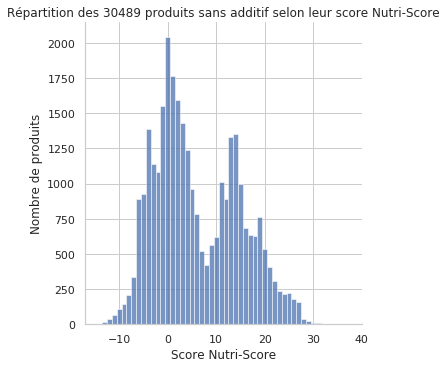

In [57]:
# Distribution du score final Nutri-Score parmi la classe 'Pas d'additifs'
filtered_data = open_food_facts_df[open_food_facts_df['additives_n_classes'] == 'Pas d\'additif']
nombre_produits = filtered_data['nutriscore_score'].count()
sns.displot(x='nutriscore_score', data=filtered_data, discrete=True)
plt.title('Répartition des {} produits sans additif selon leur score Nutri-Score'.format(nombre_produits))
plt.xlabel('Score Nutri-Score')
plt.ylabel('Nombre de produits')

In [61]:
filtered_data['nutriscore_score'].describe()

count    30489.000000
mean         6.094198
std          8.751638
min        -14.000000
25%         -1.000000
50%          4.000000
75%         13.000000
max         37.000000
Name: nutriscore_score, dtype: float64

In [59]:
st.skew(filtered_data['nutriscore_score'])

0.40242696396146305

In [60]:
st.kurtosis(filtered_data['nutriscore_score'])

-0.7744059261756844

Graphiquement, la distribution est bimodale et ne semble pas suivre une loi normale, cependant le skewness et le kurtosis sont proches de 0. Testons avec un test d'Agostino si cette classe suit la loi normale.

In [64]:
st.normaltest(filtered_data['nutriscore_score'])

NormaltestResult(statistic=3057.6414829337646, pvalue=0.0)

Au niveau de test 5%, nous rejetons l'hypothèse affirmant que la distribution suit une loi normale.

La première hypothèse citée ci-avant pour réaliser l'ANOVA n'est pas vérifiée. De ce fait, nous allons utiliser la variable 'nutriscore_grade' pour pouvoir répondre à l'interrogation. Ceci étant posé nous allons calculer le tableau de contingence.

In [66]:
X = 'nutriscore_grade'
Y = 'additives_n_classes'

tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len)

tableau_contingence

additives_n_classes  1 ou 2 additifs  Entre 3 et 7 additifs  Pas d'additif  \
nutriscore_grade                                                             
a                               4875                   1629           7800   
b                               5028                   3423           5246   
c                               9482                   6392           6280   
d                              10812                  10077           7568   
e                              10327                   7395           3595   

additives_n_classes  Plus de 7 additifs  
nutriscore_grade                         
a                                   170  
b                                   417  
c                                   862  
d                                  2109  
e                                   813

Testons alors l'indépendance entre ces deux variables avec le test du khi-deux.

In [67]:
st.chi2_contingency(tableau_contingence)

(8408.717208004593,
 0.0,
 12,
 array([[ 5623.62776606,  4012.75344199,  4231.04301055,   606.5757814 ],
        [ 5483.7558581 ,  3912.9474976 ,  4125.80772771,   591.48891659],
        [ 8942.47731544,  6380.92671141,  6728.04241611,   964.55355705],
        [11875.90205177,  8474.07915628,  8935.0601534 ,  1280.95863854],
        [ 8598.23700863,  6135.29319271,  6469.04669223,   927.42310642]]))

À 5%, nous rejetons l'hypothèse nulle affirmant que les variables 'nutriscore_grade' et 'additives_n_classes' sont indépendantes. Par conséquent, il y a une dépendance significative entre le nombre d'additifs présents dans les produits et leur qualité nutritionnelle.

Text(0, 0.5, "Nombre d'additifs")

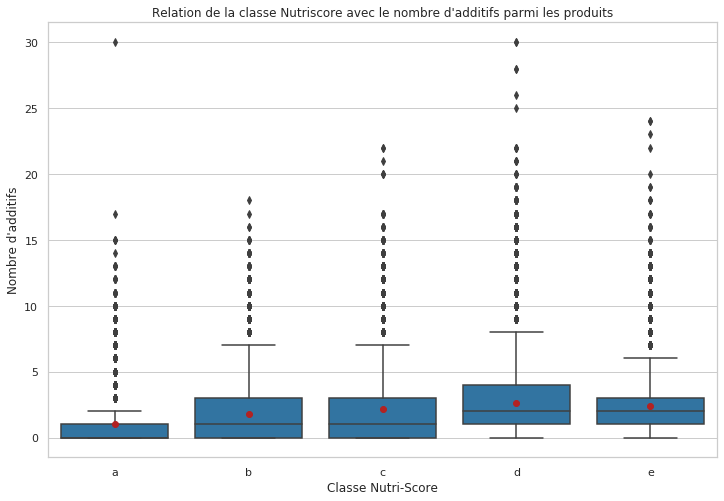

In [75]:
meanprops = {'marker':'o', 'markeredgecolor':'firebrick',
            'markerfacecolor':'firebrick'}

plt.rcParams["figure.figsize"] = (12, 8)
sns.boxplot(x='nutriscore_grade', y='additives_n', 
            data=open_food_facts_df, color='tab:blue',
            order=['a', 'b', 'c', 'd', 'e'],
            showmeans=True,
            meanprops=meanprops)
plt.title('Relation de la classe Nutriscore avec le nombre d\'additifs parmi les produits')
plt.xlabel('Classe Nutri-Score')
plt.ylabel('Nombre d\'additifs')

On observe des nombres d'additifs moyen et médian plus faible dans les classes de produits de meilleure qualité nutritionnelle. Voyons si cette différence est significative avec une ANOVA.

Vérifions d'abord les hypothèses nécessaires à l'ANOVA.

*Classe a*

Text(-3.8249999999999957, 0.5, 'Nombre de produits de classe a')

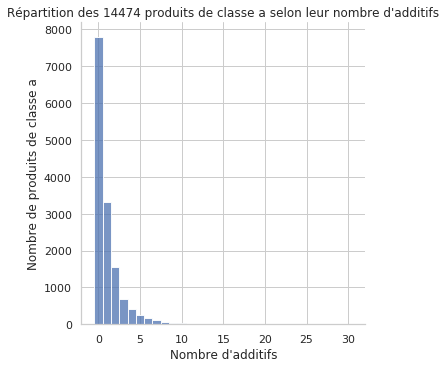

In [81]:
# Distribution du nombre d'additifs parmi la classe a des produits
filtered_data = open_food_facts_df[open_food_facts_df['nutriscore_grade'] == 'a']
nombre_produits = filtered_data['additives_n'].count()
sns.displot(x='additives_n', data=filtered_data, discrete=True)
plt.title('Répartition des {} produits de classe a selon leur nombre d\'additifs'.format(nombre_produits))
plt.xlabel('Nombre d\'additifs')
plt.ylabel('Nombre de produits de classe a')

In [85]:
st.normaltest(filtered_data['additives_n'])

NormaltestResult(statistic=9653.887174156096, pvalue=0.0)

La distribution ne suit donc pas une loi normale avec un risque de 5%. L'ANOVA n'est donc pas faisable.

**Conclusion de cette hypothèse :** selon les résultats empiriques, il semblerait que plus nous avons un nombre d'additifs faible dans les produits et meilleure est la qualité nutritionnelle des produits. Cependant, cela n'est pas significatif car les hypothèses du test d'ANOVA n'ont pas été vérifiées et donc cela n'a pas pu être testé.
En revanche, il y a une dépendance significative entre le nombre d'additifs et la qualité nutritionnelle.

In [90]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 10 columns):
brands_tags            103844 non-null object
labels_en              71866 non-null object
additives_tags         73811 non-null object
nutriscore_grade       104300 non-null object
pnns_groups_1          104159 non-null object
pnns_groups_2          104300 non-null object
additives_n            104300 non-null float64
nutriscore_score       104300 non-null float64
nova_group             104067 non-null object
additives_n_classes    104300 non-null object
dtypes: float64(2), object(8)
memory usage: 8.0+ MB


## Y a-t-il plus d'additifs dans les produits ultra-transformés ? Ou la présence d'additifs est-elle plus importante parmi ces produits ?

Text(0, 0.5, "Nombre d'additifs")

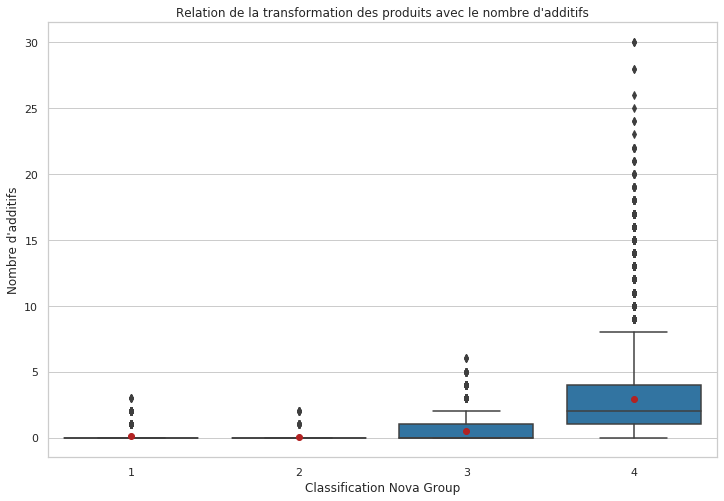

In [91]:
meanprops = {'marker':'o', 'markeredgecolor':'firebrick',
            'markerfacecolor':'firebrick'}

plt.rcParams["figure.figsize"] = (12, 8)
sns.boxplot(x='nova_group', y='additives_n', 
            data=open_food_facts_df, color='tab:blue',
            order=[1, 2, 3, 4],
            showmeans=True,
            meanprops=meanprops)
plt.title('Relation de la transformation des produits avec le nombre d\'additifs')
plt.xlabel('Classification Nova Group')
plt.ylabel('Nombre d\'additifs')

On peut voir que plus le produit est transformé et plus le nombre moyen d'additifs dans le produit est élevé. De plus, les produits avec les nombres d'additifs les plus élevés font partie des produits ultra-transformés.

Montrons que cette corrélation est significative avec un test du khi-2, en utilisant le nombre d'additifs regroupé par classe.

In [92]:
X = 'nova_group'
Y = 'additives_n_classes'

tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len)

tableau_contingence

additives_n_classes  1 ou 2 additifs  Entre 3 et 7 additifs  Pas d'additif  \
nova_group                                                                   
1.0                            848.0                    4.0         7766.0   
2.0                             22.0                    NaN         1002.0   
3.0                           7196.0                  538.0        15058.0   
4.0                          32239.0                28360.0         6663.0   

additives_n_classes  Plus de 7 additifs  
nova_group                               
1.0                                 NaN  
2.0                                 NaN  
3.0                                 NaN  
4.0                              4371.0

Regroupons les classes entre elles car les effectifs sont insuffisants pour un test du khi-2.
Voici les nouvelles classes :
- "Sans additif" et "Avec additifs"
- "Peu ou pas de transformation" et "Ultra-transformation"

In [14]:
open_food_facts_df.loc[(open_food_facts_df['nova_group'] == 1) | (open_food_facts_df['nova_group'] == 2) |
                       (open_food_facts_df['nova_group'] == 3), 
                       'nova_group_classes'] = 'Peu ou pas de transformation'
open_food_facts_df.loc[open_food_facts_df['nova_group'] == 4, 'nova_group_classes'] = 'Ultra transformation'
open_food_facts_df.loc[open_food_facts_df['additives_n'] == 0, 'additives_n_classes_k2'] = 'Sans additif'
open_food_facts_df.loc[open_food_facts_df['additives_n'] > 0, 'additives_n_classes_k2'] = 'Avec additif'

In [15]:
open_food_facts_df[['additives_n_classes', 'additives_n_classes_k2']].sample(30)

additives_n_classes additives_n_classes_k2
5037   Entre 3 et 7 additifs           Avec additif
29541          Pas d'additif           Sans additif
80003        1 ou 2 additifs           Avec additif
79957          Pas d'additif           Sans additif
81444          Pas d'additif           Sans additif
830            Pas d'additif           Sans additif
56419          Pas d'additif           Sans additif
61699        1 ou 2 additifs           Avec additif
33279  Entre 3 et 7 additifs           Avec additif
96600  Entre 3 et 7 additifs           Avec additif
40981        1 ou 2 additifs           Avec additif
77485        1 ou 2 additifs           Avec additif
9590   Entre 3 et 7 additifs           Avec additif
97527     Plus de 7 additifs           Avec additif
57553        1 ou 2 additifs           Avec additif
51464          Pas d'additif           Sans additif
84048        1 ou 2 additifs           Avec additif
42857          Pas d'additif           Sans additif
55555          Pas d'additif           Sans additif
7211         1 ou 2 additifs           Avec additif
52826        1 ou 2 additifs           Avec additif
37639          Pas d'additif           Sans additif
40336  Entre 3 et 7 additifs           Avec additif
38153  Entre 3 et 7 additifs           Avec additif
11667        1 ou 2 additifs           Avec additif
86249          Pas d'additif           Sans additif
69128  Entre 3 et 7 additifs           Avec additif
30737          Pas d'additif           Sans additif
54122          Pas d'additif           Sans additif
76882  Entre 3 et 7 additifs           Avec additif

In [16]:
open_food_facts_df[['nova_group', 'nova_group_classes']].sample(30)

nova_group            nova_group_classes
22438           4          Ultra transformation
44430           1  Peu ou pas de transformation
65123           3  Peu ou pas de transformation
4853            4          Ultra transformation
45121           3  Peu ou pas de transformation
49710           4          Ultra transformation
85822           4          Ultra transformation
14709           3  Peu ou pas de transformation
402             3  Peu ou pas de transformation
96556           4          Ultra transformation
98766           4          Ultra transformation
67279           1  Peu ou pas de transformation
58286           3  Peu ou pas de transformation
79412           1  Peu ou pas de transformation
100014          4          Ultra transformation
102618          4          Ultra transformation
74760           3  Peu ou pas de transformation
95466           3  Peu ou pas de transformation
5067            4          Ultra transformation
94356         NaN                           NaN
7258            4          Ultra transformation
18649           3  Peu ou pas de transformation
32472           4          Ultra transformation
2241            4          Ultra transformation
60025           3  Peu ou pas de transformation
102891          4          Ultra transformation
9612            4          Ultra transformation
82779           1  Peu ou pas de transformation
45366           4          Ultra transformation
37742           4          Ultra transformation

In [98]:
X = 'nova_group_classes'
Y = 'additives_n_classes_k2'

tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len)

tableau_contingence

additives_n_classes_k2        Avec additif  Sans additif
nova_group_classes                                      
Peu ou pas de transformation          8608         23826
Ultra transformation                 64970          6663

In [99]:
st.chi2_contingency(tableau_contingence)

(44362.075725243056, 0.0, 1, array([[22931.65798956,  9502.34201044],
        [50646.34201044, 20986.65798956]]))

Avec un risque de 5%, nous rejetons l'hypothèse déclarant que les variables 'nova_group_classes' et 'additives_n_classes_k2' sont indépendantes. Par conséquent, la transformation du produit et la présence d'additifs sont significativement corrélés.

**Conclusion de cette hypothèse :** la corrélation entre la transformation des produits et la présence d'additifs est significatif pour un risque de 5% (p-value = 0.0). Grâce aux résultats empiriques, on observe que plus un produit est transformé et plus le nombre d'additifs qu'il contient est élevé.

In [109]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 12 columns):
brands_tags               103844 non-null object
labels_en                 71866 non-null object
additives_tags            73811 non-null object
nutriscore_grade          104300 non-null object
pnns_groups_1             104159 non-null object
pnns_groups_2             104300 non-null object
additives_n               104300 non-null float64
nutriscore_score          104300 non-null float64
nova_group                104067 non-null object
additives_n_classes       104300 non-null object
nova_group_classes        104067 non-null object
additives_n_classes_k2    104300 non-null object
dtypes: float64(2), object(10)
memory usage: 9.5+ MB


## Y a-t-il plus d'additifs dans certaines catégories de produits ? Ou leur présence est-elle plus forte dans certaines d'entre elles ?

Text(0.5, 0, "Nombre d'additifs")

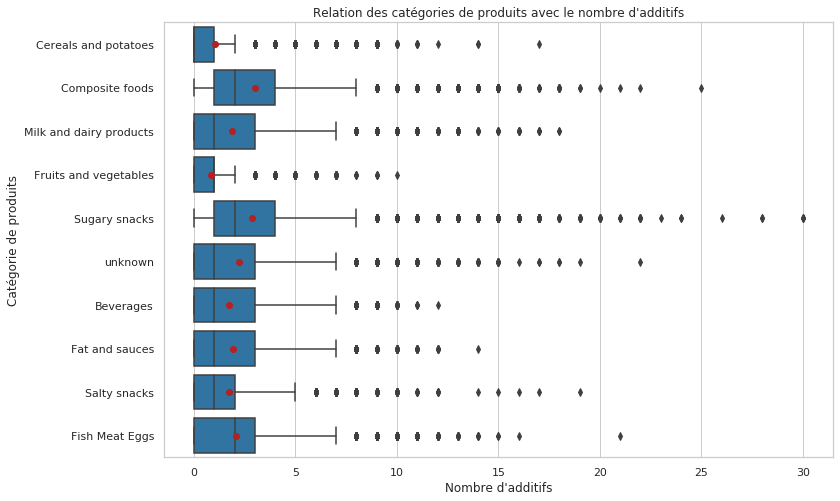

In [110]:
meanprops = {'marker':'o', 'markeredgecolor':'firebrick',
            'markerfacecolor':'firebrick'}

plt.rcParams["figure.figsize"] = (12, 8)
sns.boxplot(x='additives_n', y='pnns_groups_1', 
            data=open_food_facts_df, color='tab:blue',
            showmeans=True,
            meanprops=meanprops)
plt.title('Relation des catégories de produits avec le nombre d\'additifs')
plt.ylabel('Catégorie de produits')
plt.xlabel('Nombre d\'additifs')

Parmi les catégories "Plats préparés" et "Snacks sucrés", le nombre moyen et médian d'additifs est plus élevé que dans les autres catégories. De plus, la dispersion de ce nombre y sont plus fort.

Vérifions s'il y a une corrélation significative avec un test du khi-2 grâce aux classes créées.

In [111]:
X = 'pnns_groups_1'
Y = 'additives_n_classes'

tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len)

tableau_contingence

additives_n_classes      1 ou 2 additifs  Entre 3 et 7 additifs  \
pnns_groups_1                                                     
Beverages                           2869                   2021   
Cereals and potatoes                2584                   1245   
Composite foods                     4488                   4714   
Fat and sauces                      2129                   1472   
Fish Meat Eggs                      5177                   3694   
Fruits and vegetables               3371                    339   
Milk and dairy products             3746                   3358   
Salty snacks                        2943                   1599   
Sugary snacks                      10874                   8619   
unknown                             2288                   1777   

additives_n_classes      Pas d'additif  Plus de 7 additifs  
pnns_groups_1                                               
Beverages                         2786                 131  
Cereals and potatoes              4822                  74  
Composite foods                   2702                1194  
Fat and sauces                    1694                 101  
Fish Meat Eggs                    3458                 360  
Fruits and vegetables             3135                   7  
Milk and dairy products           4969                 387  
Salty snacks                      2250                 105  
Sugary snacks                     2882                1719  
unknown                           1791                 285

In [112]:
st.chi2_contingency(tableau_contingence)

(12065.09679981136,
 0.0,
 27,
 array([[3033.26148485, 2161.486439  , 2285.23337398,  327.01870218],
        [3389.93293906, 2415.64867174, 2553.94661047,  365.47177872],
        [5088.97898405, 3626.38009197, 3833.99343312,  548.64749086],
        [2096.51325378, 1493.96449659, 1579.49523325,  226.02701639],
        [4930.06980674, 3513.14223447, 3714.27261206,  531.51534673],
        [2662.21438378, 1897.0801947 , 2005.68964756,  287.01577396],
        [4841.09620868, 3449.74010887, 3647.24066091,  521.92302153],
        [2679.69827859, 1909.53912768, 2018.86186503,  288.90072869],
        [9361.26581476, 6670.78958131, 7052.69795217, 1009.24665175],
        [2385.96884571, 1700.22905366, 1797.56861145,  257.23348918]]))

En effet, la corrélation entre le nombre d'additifs et la catégorie de produits est significative au seuil de 5% (p-value = 0.0). Faisons le même test avec la présence ou absence d'additifs.

In [113]:
X = 'pnns_groups_1'
Y = 'additives_n_classes_k2'

tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len)

tableau_contingence

additives_n_classes_k2   Avec additif  Sans additif
pnns_groups_1                                      
Beverages                        5021          2786
Cereals and potatoes             3903          4822
Composite foods                 10396          2702
Fat and sauces                   3702          1694
Fish Meat Eggs                   9231          3458
Fruits and vegetables            3717          3135
Milk and dairy products          7491          4969
Salty snacks                     4647          2250
Sugary snacks                   21212          2882
unknown                          4350          1791

In [114]:
st.chi2_contingency(tableau_contingence)

(8613.017633496876, 0.0, 9, array([[ 5521.76662602,  2285.23337398],
        [ 6171.05338953,  2553.94661047],
        [ 9264.00656688,  3833.99343312],
        [ 3816.50476675,  1579.49523325],
        [ 8974.72738794,  3714.27261206],
        [ 4846.31035244,  2005.68964756],
        [ 8812.75933909,  3647.24066091],
        [ 4878.13813497,  2018.86186503],
        [17041.30204783,  7052.69795217],
        [ 4343.43138855,  1797.56861145]]))

La corrélation est également significative au seuil de 5% (p-value = 0.0) entre la présence d'additifs et la catégorie de produits.

**Conclusion de cette hypothèse :** la corrélation entre la catégorie des produits et la présence d'additifs est significative pour un risque de 5% (p-value = 0.0) mais également entre la catégorie des produits et le nombre d'additifs. Empiriquement, les produits des catégories "Plats préparés" et "Snacks sucrés" ont un nombre moyen et médian plus élevés que dans les autres catégories.

## Y a-t-il plus d'additifs dans certaines sous-catégories de produits ? Ou leur présence est-elle plus forte dans certaines d'entre elles ?

Text(0.5, 0, "Nombre d'additifs")

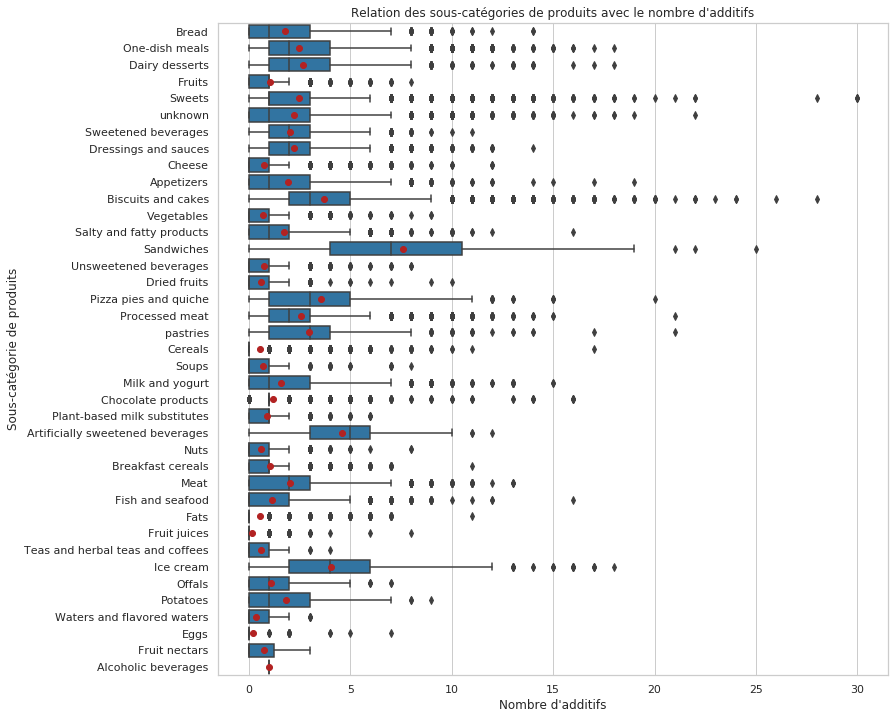

In [13]:
meanprops = {'marker':'o', 'markeredgecolor':'firebrick',
            'markerfacecolor':'firebrick'}

plt.rcParams["figure.figsize"] = (12, 12)
sns.boxplot(x='additives_n', y='pnns_groups_2', 
            data=open_food_facts_df, color='tab:blue',
            showmeans=True,
            meanprops=meanprops)
plt.title('Relation des sous-catégories de produits avec le nombre d\'additifs')
plt.ylabel('Sous-catégorie de produits')
plt.xlabel('Nombre d\'additifs')

Le nombre d'additifs moyen et médian sont plus élevés parmi les catégories "Glaces", "Boissons sucrées édulcorées", "Sandwichs", "Pâtisseries", "Pizzas, tartes et quiches" et "Biscuits et gâteaux".

Vérifions si cette dépendance est significative avec un test du khi-2.

In [17]:
X = 'pnns_groups_2'
Y = 'additives_n_classes'

tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len)

tableau_contingence

additives_n_classes               1 ou 2 additifs  Entre 3 et 7 additifs  \
pnns_groups_2                                                              
Alcoholic beverages                           2.0                    NaN   
Appetizers                                  936.0                  792.0   
Artificially sweetened beverages            164.0                  826.0   
Biscuits and cakes                         3314.0                 5802.0   
Bread                                       894.0                  620.0   
Breakfast cereals                           634.0                  194.0   
Cereals                                     601.0                  219.0   
Cheese                                     1361.0                  358.0   
Chocolate products                         2461.0                  301.0   
Dairy desserts                              691.0                  923.0   
Dressings and sauces                       2040.0                 1374.0   
Dried fruits                                321.0                   29.0   
Eggs                                         15.0                    4.0   
Fats                                         89.0                   98.0   
Fish and seafood                            739.0                  398.0   
Fruit juices                                180.0                    7.0   
Fruit nectars                                37.0                    4.0   
Fruits                                     1472.0                  124.0   
Ice cream                                   518.0                 1054.0   
Meat                                       1029.0                  835.0   
Milk and yogurt                            1176.0                 1023.0   
Nuts                                        127.0                   47.0   
Offals                                      162.0                   40.0   
One-dish meals                             4066.0                 3579.0   
Pizza pies and quiche                       382.0                  778.0   
Plant-based milk substitutes                252.0                   49.0   
Potatoes                                    261.0                  201.0   
Processed meat                             3232.0                 2417.0   
Salty and fatty products                   1880.0                  760.0   
Sandwiches                                   93.0                  435.0   
Soups                                       394.0                   27.0   
Sweetened beverages                        1827.0                 1034.0   
Sweets                                     4623.0                 1839.0   
Teas and herbal teas and coffees             12.0                    3.0   
Unsweetened beverages                       357.0                   94.0   
Vegetables                                 1378.0                  170.0   
Waters and flavored waters                   40.0                    4.0   
pastries                                    476.0                  677.0   
unknown                                    2288.0                 1777.0   

additives_n_classes               Pas d'additif  Plus de 7 additifs  
pnns_groups_2                                                        
Alcoholic beverages                         NaN                 NaN  
Appetizers                                893.0                79.0  
Artificially sweetened beverages            3.0               109.0  
Biscuits and cakes                        867.0              1087.0  
Bread                                     760.0                48.0  
Breakfast cereals                         683.0                 1.0  
Cereals                                  2663.0                22.0  
Cheese                                   2512.0                19.0  
Chocolate products                        813.0                23.0  
Dairy desserts                            505.0                96.0  
Dressings and sauces                      8

Certains effectifs sont insuffisants (< 5) pour réaliser le test du khi-2 sur ces données. De ce fait, nous allons utiliser la variable "additives_n_classes_k2" qui exprime la présence ou l'absence d'additifs. Et nous allons regrouper les boissons alcoolisés avec les boissons non sucrées.

In [15]:
open_food_facts_df['pnns_groups_2_classes'] = open_food_facts_df['pnns_groups_2']
open_food_facts_df.loc[open_food_facts_df['pnns_groups_2'] == 'Alcoholic beverages', 
                       'pnns_groups_2_classes'] = 'Unsweetened beverages'

In [20]:
open_food_facts_df.loc[open_food_facts_df['pnns_groups_2'] == 'Alcoholic beverages', 
                   ['pnns_groups_2', 'pnns_groups_2_classes']]

pnns_groups_2  pnns_groups_2_classes
11749   Alcoholic beverages  Unsweetened beverages
100449  Alcoholic beverages  Unsweetened beverages

In [21]:
X = 'pnns_groups_2_classes'
Y = 'additives_n_classes_k2'

tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len)

tableau_contingence

additives_n_classes_k2            Avec additif  Sans additif
pnns_groups_2_classes                                       
Appetizers                                1807           893
Artificially sweetened beverages          1099             3
Biscuits and cakes                       10203           867
Bread                                     1562           760
Breakfast cereals                          829           683
Cereals                                    842          2663
Cheese                                    1738          2512
Chocolate products                        2785           813
Dairy desserts                            1710           505
Dressings and sauces                      3514           842
Dried fruits                               352           495
Eggs                                        19           188
Fats                                       188           852
Fish and seafood                          1172          1475
Fruit juices                               188          1261
Fruit nectars                               41            51
Fruits                                    1597           598
Ice cream                                 1760            91
Meat                                      1943           832
Milk and yogurt                           2283          1861
Nuts                                       176           400
Offals                                     202           140
One-dish meals                            8205          2488
Pizza pies and quiche                     1264           169
Plant-based milk substitutes               301           271
Potatoes                                   465           205
Processed meat                            5895           823
Salty and fatty products                  2664           957
Sandwiches                                1066            45
Soups                                      422           425
Sweetened beverages                       2879           405
Sweets                                    7021          1022
Teas and herbal teas and coffees            15            28
Unsweetened beverages                      456           651
Vegetables                                1551          2128
Waters and flavored waters                  44           116
pastries                                  1203           180
unknown                                   4350          1791

Ici encore, il reste un effectif < 5, les catégories "Boissons sucrées" et "Boissons édulcorées" seront regroupées.

In [16]:
open_food_facts_df.loc[open_food_facts_df['pnns_groups_2'] == 'Artificially sweetened beverages', 
                       'pnns_groups_2_classes'] = 'Sweetened beverages'

In [17]:
open_food_facts_df.loc[open_food_facts_df['pnns_groups_2'] == 'Artificially sweetened beverages', 
                   ['pnns_groups_2', 'pnns_groups_2_classes']]

pnns_groups_2 pnns_groups_2_classes
132     Artificially sweetened beverages   Sweetened beverages
230     Artificially sweetened beverages   Sweetened beverages
231     Artificially sweetened beverages   Sweetened beverages
355     Artificially sweetened beverages   Sweetened beverages
433     Artificially sweetened beverages   Sweetened beverages
...                                  ...                   ...
104105  Artificially sweetened beverages   Sweetened beverages
104118  Artificially sweetened beverages   Sweetened beverages
104119  Artificially sweetened beverages   Sweetened beverages
104246  Artificially sweetened beverages   Sweetened beverages
104278  Artificially sweetened beverages   Sweetened beverages

[1102 rows x 2 columns]

In [24]:
X = 'pnns_groups_2_classes'
Y = 'additives_n_classes_k2'

tableau_contingence = open_food_facts_df[[X, Y]].pivot_table(index=X, 
                                                             columns=Y, 
                                                             aggfunc=len)

tableau_contingence

additives_n_classes_k2            Avec additif  Sans additif
pnns_groups_2_classes                                       
Appetizers                                1807           893
Biscuits and cakes                       10203           867
Bread                                     1562           760
Breakfast cereals                          829           683
Cereals                                    842          2663
Cheese                                    1738          2512
Chocolate products                        2785           813
Dairy desserts                            1710           505
Dressings and sauces                      3514           842
Dried fruits                               352           495
Eggs                                        19           188
Fats                                       188           852
Fish and seafood                          1172          1475
Fruit juices                               188          1261
Fruit nectars                               41            51
Fruits                                    1597           598
Ice cream                                 1760            91
Meat                                      1943           832
Milk and yogurt                           2283          1861
Nuts                                       176           400
Offals                                     202           140
One-dish meals                            8205          2488
Pizza pies and quiche                     1264           169
Plant-based milk substitutes               301           271
Potatoes                                   465           205
Processed meat                            5895           823
Salty and fatty products                  2664           957
Sandwiches                                1066            45
Soups                                      422           425
Sweetened beverages                       3978           408
Sweets                                    7021          1022
Teas and herbal teas and coffees            15            28
Unsweetened beverages                      456           651
Vegetables                                1551          2128
Waters and flavored waters                  44           116
pastries                                  1203           180
unknown                                   4350          1791

In [25]:
st.chi2_contingency(tableau_contingence)

(21555.919881480313, 0.0, 36, array([[1910.73537872,  789.26462128],
        [7834.01505273, 3235.98494727],
        [1643.2324257 ,  678.7675743 ],
        [1070.01181208,  441.98818792],
        [2480.41759348, 1024.58240652],
        [3007.63902205, 1242.36097795],
        [2546.23181208, 1051.76818792],
        [1567.51069032,  647.48930968],
        [3082.65307766, 1273.34692234],
        [ 599.4047651 ,  247.5952349 ],
        [ 146.48971237,   60.51028763],
        [ 735.98696069,  304.01303931],
        [1873.22835091,  773.77164909],
        [1025.42798658,  423.57201342],
        [  65.10653883,   26.89346117],
        [1553.35709492,  641.64290508],
        [1309.91525407,  541.08474593],
        [1963.81136146,  811.18863854],
        [2932.62496644, 1211.37503356],
        [ 407.62354746,  168.37645254],
        [ 242.0264813 ,   99.9735187 ],
        [7567.21977948, 3125.78022052],
        [1014.10511026,  418.89488974],
        [ 404.79282838,  167.20717162],
        [ 4

Au niveau de risque fixé à 5%, nous rejetons l'hypothèse nulle, par conséquent les variables "sous-catégories de produit" et "présence d'additifs" sont dépendantes entre elles.

**Conclusion de cette hypothèse :** nous avons une dépendance significative entre la sous-catégorie de produits et la présence d'additifs au seuil de 5%. Avec les résultats empiriques on observe un nombre d'additifs moyen et médian plus élevés dans les sous-catégories suivantes :
- Glaces
- Boissons sucrées édulcorées
- Sandwichs
- Pâtisseries
- Pizzas, tartes et quiches
- Biscuits et gâteaux

# Imputation des données

In [8]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   brands_tags       103844 non-null  object 
 1   labels_en         71866 non-null   object 
 2   additives_tags    73811 non-null   object 
 3   nutriscore_grade  104300 non-null  object 
 4   pnns_groups_1     104159 non-null  object 
 5   pnns_groups_2     104300 non-null  object 
 6   additives_n       104300 non-null  float64
 7   nutriscore_score  104300 non-null  float64
 8   nova_group        104067 non-null  object 
dtypes: float64(2), object(7)
memory usage: 7.2+ MB


In [14]:
donnees_manquantes_df

nombre   total  pourcentage
labels_en        32434  104300         31.1
additives_tags   30489  104300         29.2
brands_tags        456  104300          0.4
nova_group         233  104300          0.2
pnns_groups_1      141  104300          0.1

## Variable *additives_tags*

Voyons si les données manquantes de cette variable correspondent à un nombre d'additifs à 0. Cela correspondrait donc à une liste vide d'additif.

In [37]:
filtered_data = open_food_facts_df[open_food_facts_df['additives_tags'].isna()]
filtered_data['additives_tags'].fillna('vide', inplace=True)

In [38]:
X = 'additives_tags'
Y = 'additives_n'

tableau_contingence = filtered_data[[X, Y]].pivot_table(index=X, 
                                                        columns=Y, 
                                                        aggfunc=len,
                                                        margins=True)

tableau_contingence

additives_n       0.0    All
additives_tags              
vide            30489  30489
All             30489  30489

Toutes les données manquantes correspondent en effet à un nombre nul d'additifs.

In [31]:
open_food_facts_df['additives_tags'].describe()

count                73811
unique               19093
top       en:e322,en:e322i
freq                  3834
Name: additives_tags, dtype: object

In [35]:
open_food_facts_df['additives_tags'].value_counts()

en:e322,en:e322i                                                                                            3834
en:e330                                                                                                     2802
en:e440                                                                                                     2540
en:e14xx                                                                                                    1969
en:e300                                                                                                     1870
                                                                                                            ... 
en:e150c,en:e160c,en:e163,en:e330                                                                              1
en:e1103,en:e163,en:e270,en:e330,en:e420                                                                       1
en:e150a,en:e250,en:e262,en:e316,en:e330,en:e331,en:e450,en:e451,en:e621                        

In [39]:
open_food_facts_df['additives_tags'].str.find("no").describe()

count    73811.0
mean        -1.0
std          0.0
min         -1.0
25%         -1.0
50%         -1.0
75%         -1.0
max         -1.0
Name: additives_tags, dtype: float64

On impute donc les valeurs manquantes de cette variable par 'no additives'.

In [21]:
open_food_facts_df['additives_tags'].fillna('no additives', inplace=True)

In [22]:
open_food_facts_df['additives_tags'].value_counts()

no additives                                                           30489
en:e322,en:e322i                                                        3834
en:e330                                                                 2802
en:e440                                                                 2540
en:e14xx                                                                1969
                                                                       ...  
en:e160a,en:e160ai,en:e202,en:e306,en:e322,en:e322i,en:e330,en:e471        1
en:e120,en:e127,en:e133,en:e150,en:e202,en:e220,en:e330,en:e415            1
en:e1510,en:e202,en:e415,en:e420,en:e450,en:e450i,en:e471,en:e500          1
en:e250,en:e282,en:e301                                                    1
en:e322,en:e322i,en:e471,en:e472e,en:e481                                  1
Name: additives_tags, Length: 19094, dtype: int64

In [18]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 9 columns):
brands_tags         103844 non-null object
labels_en           71866 non-null object
additives_tags      104300 non-null object
nutriscore_grade    104300 non-null object
pnns_groups_1       104159 non-null object
pnns_groups_2       104300 non-null object
additives_n         104300 non-null float64
nutriscore_score    104300 non-null float64
nova_group          104067 non-null object
dtypes: float64(2), object(7)
memory usage: 7.2+ MB


## Variable *pnns_groups_1*

In [19]:
open_food_facts_df['pnns_groups_1'].value_counts()

Sugary snacks              24094
Composite foods            13098
Fish Meat Eggs             12689
Milk and dairy products    12460
Cereals and potatoes        8725
Beverages                   7807
Salty snacks                6897
Fruits and vegetables       6852
unknown                     6141
Fat and sauces              5396
Name: pnns_groups_1, dtype: int64

In [48]:
filtered_data = open_food_facts_df[open_food_facts_df['pnns_groups_1'].isna()]
filtered_data['pnns_groups_1'].fillna('vide', inplace=True)

In [49]:
X = 'pnns_groups_1'
Y = 'pnns_groups_2'

tableau_contingence = filtered_data[[X, Y]].pivot_table(index=X, 
                                                        columns=Y, 
                                                        aggfunc=len,
                                                        margins=True)

tableau_contingence

pnns_groups_2  Alcoholic beverages  Pizza pies and quiche  All
pnns_groups_1                                                 
vide                             2                    139  141
All                              2                    139  141

In [51]:
filtered_data = open_food_facts_df[open_food_facts_df['pnns_groups_2'] == 'Pizza pies and quiche']

In [52]:
X = 'pnns_groups_1'
Y = 'pnns_groups_2'

tableau_contingence = filtered_data[[X, Y]].pivot_table(index=X, 
                                                        columns=Y, 
                                                        aggfunc=len,
                                                        margins=True)

tableau_contingence

pnns_groups_2    Pizza pies and quiche   All
pnns_groups_1                               
Composite foods                   1294  1294
All                               1294  1294

Les catégories vides correspondant à la sous-catégorie 'Pizza pies and quiche' seront remplacées par 'Composite foods'. Et celles parmi les boissons alcoolisées seront catégorisées dans 'Beverages'.

In [23]:
open_food_facts_df.loc[open_food_facts_df['pnns_groups_2'] == 'Pizza pies and quiche',
                      'pnns_groups_1'] = 'Composite foods'

In [24]:
open_food_facts_df[open_food_facts_df['pnns_groups_2'] == 'Pizza pies and quiche']['pnns_groups_1'].describe()

count                1433
unique                  1
top       Composite foods
freq                 1433
Name: pnns_groups_1, dtype: object

In [25]:
open_food_facts_df.loc[open_food_facts_df['pnns_groups_2'] == 'Alcoholic beverages',
                      'pnns_groups_1'] = 'Beverages'

In [26]:
open_food_facts_df[open_food_facts_df['pnns_groups_2'] == 'Alcoholic beverages']['pnns_groups_1'].describe()

count             2
unique            1
top       Beverages
freq              2
Name: pnns_groups_1, dtype: object

In [27]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   brands_tags             103844 non-null  object 
 1   labels_en               71866 non-null   object 
 2   additives_tags          104300 non-null  object 
 3   nutriscore_grade        104300 non-null  object 
 4   pnns_groups_1           104300 non-null  object 
 5   pnns_groups_2           104300 non-null  object 
 6   additives_n             104300 non-null  float64
 7   nutriscore_score        104300 non-null  float64
 8   nova_group              104067 non-null  object 
 9   additives_n_classes     104300 non-null  object 
 10  nova_group_classes      104067 non-null  object 
 11  additives_n_classes_k2  104300 non-null  object 
dtypes: float64(2), object(10)
memory usage: 9.5+ MB


## Variable *nova_group*

### 1e imputation avec KNNImputer

In [54]:
imputation_knn_df = open_food_facts_df[['nutriscore_grade', 'pnns_groups_1', 'additives_n', 'nova_group']]

In [55]:
imputation_knn

nutriscore_grade            pnns_groups_1  additives_n nova_group
0                     a     Cereals and potatoes          3.0          4
1                     b          Composite foods          2.0          4
2                     b  Milk and dairy products          4.0          4
3                     b    Fruits and vegetables          1.0          4
4                     d            Sugary snacks          7.0          4
...                 ...                      ...          ...        ...
104295                d                  unknown          7.0          4
104296                d  Milk and dairy products          0.0          3
104297                e                Beverages          2.0          3
104298                e                Beverages          0.0          3
104299                a    Fruits and vegetables          1.0          3

[104300 rows x 4 columns]

Nous allons créer des flags pour chaque modalité de la variable catégorie. Et remplacer le classement Nutri-score par des chiffres, a = 1 et e = 5.

In [56]:
imputation_knn_df['nutriscore_grade'].value_counts()

d    30566
c    23016
e    22130
a    14474
b    14114
Name: nutriscore_grade, dtype: int64

In [57]:
imputation_knn_df.loc[imputation_knn_df['nutriscore_grade'] == 'a', 'nutriscore_grade'] = 1
imputation_knn_df.loc[imputation_knn_df['nutriscore_grade'] == 'b', 'nutriscore_grade'] = 2
imputation_knn_df.loc[imputation_knn_df['nutriscore_grade'] == 'c', 'nutriscore_grade'] = 3
imputation_knn_df.loc[imputation_knn_df['nutriscore_grade'] == 'd', 'nutriscore_grade'] = 4
imputation_knn_df.loc[imputation_knn_df['nutriscore_grade'] == 'e', 'nutriscore_grade'] = 5

/home/sebastien/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
imputation_knn_df['nutriscore_grade'].value_counts()

4    30566
3    23016
5    22130
1    14474
2    14114
Name: nutriscore_grade, dtype: int64

In [59]:
cat_variables = imputation_knn_df[['pnns_groups_1']]
cat_flags = pd.get_dummies(cat_variables, drop_first=True)
cat_flags.head()

pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                   1                              0   
1                                   0                              1   
2                                   0                              0   
3                                   0                              0   
4                                   0                              0   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                    0                                      0   
1                                    0                                      0   
2                                    0                                      1   
3                                    1                                      0   
4                                    0                                      0   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            1   

   pnns_groups_1_unknown  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

In [60]:
imputation_knn_df = imputation_knn_df.drop(['pnns_groups_1'], axis=1)
imputation_knn_df = pd.concat([imputation_knn_df, cat_flags], axis=1)
imputation_knn_df.head()

nutriscore_grade  additives_n nova_group  \
0                 1          3.0          4   
1                 2          2.0          4   
2                 2          4.0          4   
3                 2          1.0          4   
4                 4          7.0          4   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                   1                              0   
1                                   0                              1   
2                                   0                              0   
3                                   0                              0   
4                                   0                              0   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                    0                                      0   
1                                    0                                      0   
2                                    0                                      1   
3                                    1                                      0   
4                                    0                                      0   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            1   

   pnns_groups_1_unknown  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

In [61]:
# normalisation des données pour l'algorithme car il se base sur les distances
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
imputation_knn_df = pd.DataFrame(scaler.fit_transform(imputation_knn_df), columns = imputation_knn_df.columns)
imputation_knn_df.head()

nutriscore_grade  additives_n  nova_group  \
0              0.00     0.100000         1.0   
1              0.25     0.066667         1.0   
2              0.25     0.133333         1.0   
3              0.25     0.033333         1.0   
4              0.75     0.233333         1.0   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                 1.0                            0.0   
1                                 0.0                            1.0   
2                                 0.0                            0.0   
3                                 0.0                            0.0   
4                                 0.0                            0.0   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                  0.0                                    0.0   
1                                  0.0                                    0.0   
2                                  0.0                                    1.0   
3                                  1.0                                    0.0   
4                                  0.0                                    0.0   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          1.0   

   pnns_groups_1_unknown  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0

In [62]:
imputation_knn_df['nova_group'].describe()

count    104067.000000
mean          0.837624
std           0.291813
min           0.000000
25%           0.666667
50%           1.000000
75%           1.000000
max           1.000000
Name: nova_group, dtype: float64

In [63]:
imputation_knn_df[imputation_knn_df['nova_group'].isna()].head(15)

nutriscore_grade  additives_n  nova_group  \
92                1.00     0.033333         NaN   
197               1.00     0.166667         NaN   
261               0.25     0.033333         NaN   
578               0.75     0.100000         NaN   
649               1.00     0.033333         NaN   
868               0.00     0.033333         NaN   
1040              0.75     0.066667         NaN   
1261              0.25     0.033333         NaN   
1343              0.50     0.066667         NaN   
1358              0.75     0.033333         NaN   
1497              1.00     0.100000         NaN   
1725              0.50     0.033333         NaN   
1775              1.00     0.066667         NaN   
1776              0.50     0.033333         NaN   
1813              1.00     0.033333         NaN   

      pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
92                                   0.0                            0.0   
197                                  0.0                            0.0   
261                                  0.0                            0.0   
578                                  0.0                            0.0   
649                                  0.0                            0.0   
868                                  0.0                            0.0   
1040                                 0.0                            0.0   
1261                                 1.0                            0.0   
1343                                 0.0                            0.0   
1358                                 0.0                            0.0   
1497                                 0.0                            0.0   
1725                                 0.0                            0.0   
1775                                 0.0                            0.0   
1776                                 0.0                            0.0   
1813                                 0.0                            0.0   

      pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
92                             0.0                           0.0   
197                            0.0                           0.0   
261                            0.0                           0.0   
578                            1.0                           0.0   
649                            1.0                           0.0   
868                            0.0                           0.0   
1040                           0.0                           0.0   
1261                           0.0                           0.0   
1343                           0.0                           1.0   
1358                           0.0                           0.0   
1497                           0.0                           0.0   
1725                           0.0                           0.0   
1775                           0.0                           0.0   
1776                           0.0                           0.0   
1813                           0.0                           0.0   

      pnns_groups_1_Fruits and vegetables  \
92                                    0.0   
197                                   0.0   
261                                   0.0   
578                                   0.0   
649                                   0.0   
868                                   1.0   
1040                                  0.0   
1261                                  0.0   
1343                                  0.0   
1358                                  0.0   
1497                                  0.0   
1725                                  0.0   
1775                                  0.0   
1776                                  0.0   
1813                                  0.0   

      pnns_groups_1_Milk and dairy products  pnns_groups_1_Salty snacks  \
92                                      0.0                         0.0   
197                         

In [65]:
index_donnees_imputees = imputation_knn_df[imputation_knn_df['nova_group'].isna()].index
index_donnees_imputees

Int64Index([    92,    197,    261,    578,    649,    868,   1040,   1261,
              1343,   1358,
            ...
            101007, 101093, 101782, 103087, 103256, 103851, 103938, 104120,
            104189, 104211],
           dtype='int64', length=233)

In [67]:
# imputation des données de Nova group avec l'algo k-NN avec 5 voisins
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputation_knn_df = pd.DataFrame(imputer.fit_transform(imputation_knn_df), columns = imputation_knn_df.columns)

In [68]:
imputation_knn_df['nova_group'].describe()

count    104300.000000
mean          0.837249
std           0.291951
min           0.000000
25%           0.666667
50%           1.000000
75%           1.000000
max           1.000000
Name: nova_group, dtype: float64

In [70]:
imputation_knn_df.iloc[index_donnees_imputees].head(15)

nutriscore_grade  additives_n  nova_group  \
92                1.00     0.033333    1.000000   
197               1.00     0.166667    1.000000   
261               0.25     0.033333    0.733333   
578               0.75     0.100000    1.000000   
649               1.00     0.033333    1.000000   
868               0.00     0.033333    0.000000   
1040              0.75     0.066667    1.000000   
1261              0.25     0.033333    0.533333   
1343              0.50     0.066667    0.933333   
1358              0.75     0.033333    0.666667   
1497              1.00     0.100000    1.000000   
1725              0.50     0.033333    0.266667   
1775              1.00     0.066667    0.666667   
1776              0.50     0.033333    0.000000   
1813              1.00     0.033333    0.666667   

      pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
92                                   0.0                            0.0   
197                                  0.0                            0.0   
261                                  0.0                            0.0   
578                                  0.0                            0.0   
649                                  0.0                            0.0   
868                                  0.0                            0.0   
1040                                 0.0                            0.0   
1261                                 1.0                            0.0   
1343                                 0.0                            0.0   
1358                                 0.0                            0.0   
1497                                 0.0                            0.0   
1725                                 0.0                            0.0   
1775                                 0.0                            0.0   
1776                                 0.0                            0.0   
1813                                 0.0                            0.0   

      pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
92                             0.0                           0.0   
197                            0.0                           0.0   
261                            0.0                           0.0   
578                            1.0                           0.0   
649                            1.0                           0.0   
868                            0.0                           0.0   
1040                           0.0                           0.0   
1261                           0.0                           0.0   
1343                           0.0                           1.0   
1358                           0.0                           0.0   
1497                           0.0                           0.0   
1725                           0.0                           0.0   
1775                           0.0                           0.0   
1776                           0.0                           0.0   
1813                           0.0                           0.0   

      pnns_groups_1_Fruits and vegetables  \
92                                    0.0   
197                                   0.0   
261                                   0.0   
578                                   0.0   
649                                   0.0   
868                                   1.0   
1040                                  0.0   
1261                                  0.0   
1343                                  0.0   
1358                                  0.0   
1497                                  0.0   
1725                                  0.0   
1775                                  0.0   
1776                                  0.0   
1813                                  0.0   

      pnns_groups_1_Milk and dairy products  pnns_groups_1_Salty snacks  \
92                                      0.0                         0.0   
197                         

In [77]:
denormalized_df = pd.DataFrame(scaler.inverse_transform(imputation_knn_df), columns = imputation_knn_df.columns)
denormalized_df

nutriscore_grade  additives_n  nova_group  \
0                    1.0          3.0         4.0   
1                    2.0          2.0         4.0   
2                    2.0          4.0         4.0   
3                    2.0          1.0         4.0   
4                    4.0          7.0         4.0   
...                  ...          ...         ...   
104295               4.0          7.0         4.0   
104296               4.0          0.0         3.0   
104297               5.0          2.0         3.0   
104298               5.0          0.0         3.0   
104299               1.0          1.0         3.0   

        pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                      1.0                            0.0   
1                                      0.0                            1.0   
2                                      0.0                            0.0   
3                                      0.0                            0.0   
4                                      0.0                            0.0   
...                                    ...                            ...   
104295                                 0.0                            0.0   
104296                                 0.0                            0.0   
104297                                 0.0                            0.0   
104298                                 0.0                            0.0   
104299                                 0.0                            0.0   

        pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                                0.0                           0.0   
1                                0.0                           0.0   
2                                0.0                           0.0   
3                                0.0                           0.0   
4                                0.0                           0.0   
...                              ...                           ...   
104295                           0.0                           0.0   
104296                           0.0                           0.0   
104297                           0.0                           0.0   
104298                           0.0                           0.0   
104299                           0.0                           0.0   

        pnns_groups_1_Fruits and vegetables  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       1.0   
4                                       0.0   
...                                     ...   
104295                                  0.0   
104296                                  0.0   
104297                                  0.0   
104298                                  0.0   
104299                                  1.0   

        pnns_groups_1_Milk and dairy products  pnns_groups_1_Salty snacks  \
0                                         0.0                         0.0   
1                                         0.0                         0.0   
2                                         1.0                         0.0   
3                                         0.0                         0.0   
4                                         0.0                         0.0   
...                                       ...                         ...   
104295                                    0.0                         0.0   
104296                                    1.0                         0.0   
104297                                    0.0                         0.0   
104298                                    0.0                         0.0   
104299                                    0.0                         0.0   

        pnns_groups_1_Sugary snacks  pnns_groups_1_unknown  
0                               0.0                   

In [78]:
open_food_facts_df['nova_group'] = denormalized_df['nova_group']

In [81]:
open_food_facts_df['nova_group'].head(15)

0     4.0
1     4.0
2     4.0
3     4.0
4     4.0
5     4.0
6     4.0
7     4.0
8     4.0
9     4.0
10    4.0
11    4.0
12    4.0
13    4.0
14    4.0
Name: nova_group, dtype: float64

In [82]:
imputation_knn_df['nova_group'].head(15)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
Name: nova_group, dtype: float64

In [84]:
open_food_facts_df.iloc[index_donnees_imputees]['nova_group'].head(15)

92      4.0
197     4.0
261     3.2
578     4.0
649     4.0
868     1.0
1040    4.0
1261    2.6
1343    3.8
1358    3.0
1497    4.0
1725    1.8
1775    3.0
1776    1.0
1813    3.0
Name: nova_group, dtype: float64

Arrondir les valeurs à l'entier le plus proche ?

In [79]:
open_food_facts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104300 entries, 0 to 104299
Data columns (total 9 columns):
brands_tags         103844 non-null object
labels_en           71866 non-null object
additives_tags      104300 non-null object
nutriscore_grade    104300 non-null object
pnns_groups_1       104300 non-null object
pnns_groups_2       104300 non-null object
additives_n         104300 non-null float64
nutriscore_score    104300 non-null float64
nova_group          104300 non-null float64
dtypes: float64(3), object(6)
memory usage: 7.2+ MB


L'imputation avec KNNImputer nécessite de travailler uniquement avec des variables quantitatives. Pour cette raison, toutes les variables utilisées ont été transformées de manière à ce qu'elles soient exploitées par l'algorithme. Malgré ces transformations, on obtient des valeurs décimales pour *nova_group* alors que ses valeurs possibles sont 1, 2, 3 et 4. Cette manière d'imputer *nova_group* n'est donc pas retenue.

### Imputation avec tout type de variable avec *[knn_impute.py](https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850)*

Ce code Python permet de réaliser une imputation de variables quantitatives et qualitatives. Il pourrait donc pallier au problème rencontré lors de l'imputation précédente.

In [29]:
knn.knn_impute(target=open_food_facts_df['nova_group'],
               k_neighbors=5,
               attributes=open_food_facts_df[['nutriscore_grade', 'pnns_groups_1', 'additives_n']],
               aggregation_method="mode")

C:\Users\Administrateur\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


MemoryError: Unable to allocate 81.1 GiB for an array with shape (104300, 104300) and data type float64

Etant donné l'incapacité à allouer de la mémoire pour cette fonction, cette méthode est abandonnée.